# Relational Knowledge Distillation - Wider Dataset

https://arxiv.org/abs/1904.05068

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import boto3
import io
import os

# new libraries
from models_package.models import Teacher, Student, CustomResNet18
from torchvision import datasets, transforms, models
from data.data_loader import load_cifar10, load_cifar100, load_imagenet, load_prof, load_wider
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck
from torchvision.models.resnet import ResNet18_Weights, ResNet34_Weights
from utils.loss_functions import tkd_kdloss, DD_loss, AD_loss, RKDDistanceLoss, RKDAngleLoss
from utils.misc_tools_rkd import best_lr_rkd, rkd_train_teacher, rkd_train_student_with_distillation
from utils.compare_tools_rkd import compare_model_size, compare_inference_time, compare_performance_metrics, plot_comparison


In [2]:
# Hyperparameters
learning_rate = 0.007143281748064771
num_epochs = 240
temperature = 4.0
alpha = 0.9
momentum = 0.9
num_classes = 30
step_size = 30
gamma = 0.1
beta = 0.0
patience = 7  # for early stopping

batch_size = 16
num_workers = 2

# class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
# class_labels_new = torch.tensor([i for i in range(len(class_labels))])

In [3]:
# Load WIDER dataset


train_file = ['data/wider/trainval_wider.json']
test_file = ['data/wider/test_wider.json']

class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
class_labels_new = torch.tensor([i for i in range(len(class_labels))])


trainloader, testloader  =  load_wider(train_file, test_file, class_labels, 
                                       batch_size, num_workers) 

Compose(
    RandAugment(num_ops=2, magnitude=9, num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)
Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)


In [6]:
# # Accessing a single batch from the DataLoader
# batch = next(iter(trainloader))
# batch

In [4]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
teacher_model = models.resnet50(pretrained=True)  # Keep ResNet50 as it is
teacher_model.eval()  # Set teacher model to evaluation mode
student_model = CustomResNet18()

/home/ubuntu/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/ubuntu/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [5]:
# Ensure the final classification layer is added to the model
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, num_classes)
student_model.fc = nn.Linear(student_model.output_size, num_classes)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the student model
student_optimizer = optim.SGD(student_model.parameters(), lr=learning_rate, momentum=momentum)
student_scheduler = torch.optim.lr_scheduler.StepLR(student_optimizer, step_size=step_size, gamma=gamma)


criterion = nn.CrossEntropyLoss()
# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [6]:
torch.cuda.empty_cache()

In [7]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [8]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = "0"


## Fina the best learning rate

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 646/646 [01:38<00:00,  6.55it/s]


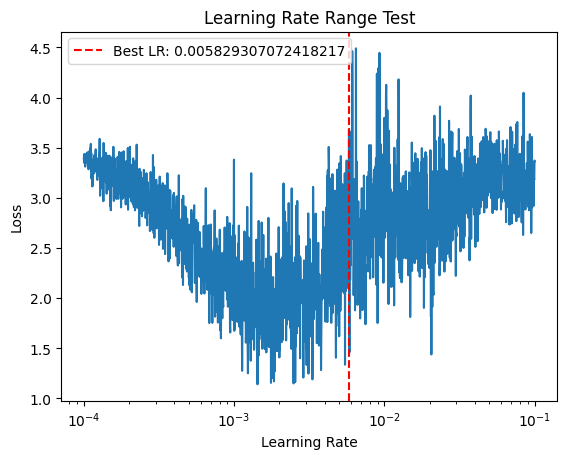

Best learning rate: 0.005829307072418217
0.005829307072418217


In [9]:
studnet_lr = best_lr_rkd(teacher_model, trainloader, criterion, 
                        teacher_optimizer, teacher_scheduler, device, num_epochs=3)  
print(studnet_lr)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 646/646 [01:37<00:00,  6.62it/s]


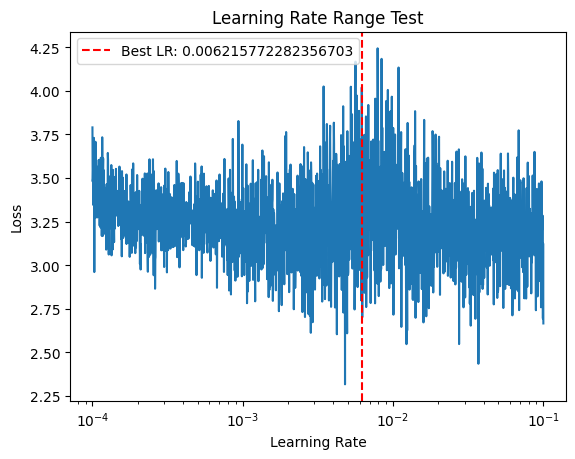

Best learning rate: 0.006215772282356703
0.006215772282356703


In [10]:
studnet_lr = best_lr_rkd(student_model, trainloader, criterion, 
                         student_optimizer, student_scheduler, device, num_epochs=3)  
print(studnet_lr)

In [11]:
teacher_lr = 0.005829307072418217
student_lr = 0.006215772282356703

In [12]:
# Ensure the final classification layer is added to the model
# num_class = 30
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, num_classes)
student_model.fc = nn.Linear(student_model.output_size, num_classes)

# Optimizer and scheduler for the student model
student_optimizer = optim.SGD(student_model.parameters(), lr=student_lr, momentum=momentum)
student_scheduler = torch.optim.lr_scheduler.StepLR(student_optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=teacher_lr, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

criterion = nn.CrossEntropyLoss()
# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Training Teacher and Student Models

In [14]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [13]:
# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Call the function to train the teacher model
rkd_train_teacher(teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=num_epochs)

# Call the function to train the student model with knowledge distillation
rkd_train_student_with_distillation(student_model, teacher_model, trainloader, criterion,
                                    student_optimizer, student_scheduler, device, alpha, 
                                    temperature, num_epochs=num_epochs)

 16%|████████████████████▎                                                                                                             | 101/646 [00:15<01:14,  7.33it/s]

[1, 100] loss: 3.332


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:30<01:14,  5.95it/s]

[1, 200] loss: 3.240


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:45<00:52,  6.60it/s]

[1, 300] loss: 3.163


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:01<00:35,  7.02it/s]

[1, 400] loss: 3.107


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:16<00:23,  6.15it/s]

[1, 500] loss: 3.080


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 599/646 [01:31<00:07,  6.56it/s]

[1, 600] loss: 3.064


 15%|████████████████████                                                                                                              | 100/646 [00:15<01:18,  6.98it/s]

[2, 100] loss: 3.008


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:31<01:11,  6.20it/s]

[2, 200] loss: 2.997


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:46<00:53,  6.41it/s]

[2, 300] loss: 2.971


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:02<00:40,  6.02it/s]

[2, 400] loss: 2.922


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:18<00:22,  6.44it/s]

[2, 500] loss: 2.895


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:33<00:06,  6.69it/s]

[2, 600] loss: 2.918


 15%|████████████████████                                                                                                               | 99/646 [00:14<01:16,  7.12it/s]

[3, 100] loss: 2.873


 31%|████████████████████████████████████████                                                                                          | 199/646 [00:29<01:04,  6.94it/s]

[3, 200] loss: 2.854


 47%|████████████████████████████████████████████████████████████▌                                                                     | 301/646 [00:45<00:52,  6.56it/s]

[3, 300] loss: 2.855


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:00<00:36,  6.70it/s]

[3, 400] loss: 2.861


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:16<00:22,  6.39it/s]

[3, 500] loss: 2.801


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:31<00:06,  6.91it/s]

[3, 600] loss: 2.758


 15%|████████████████████                                                                                                              | 100/646 [00:15<01:22,  6.61it/s]

[4, 100] loss: 2.715


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:30<01:01,  7.25it/s]

[4, 200] loss: 2.727


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:46<00:51,  6.67it/s]

[4, 300] loss: 2.713


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:01<00:38,  6.32it/s]

[4, 400] loss: 2.711


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:17<00:24,  6.00it/s]

[4, 500] loss: 2.733


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:32<00:06,  6.71it/s]

[4, 600] loss: 2.682


 15%|████████████████████                                                                                                               | 99/646 [00:15<01:28,  6.17it/s]

[5, 100] loss: 2.555


 31%|████████████████████████████████████████▍                                                                                         | 201/646 [00:31<01:10,  6.30it/s]

[5, 200] loss: 2.669


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:46<00:52,  6.56it/s]

[5, 300] loss: 2.619


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:01<00:37,  6.52it/s]

[5, 400] loss: 2.626


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:18<00:25,  5.77it/s]

[5, 500] loss: 2.612


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:33<00:06,  7.17it/s]

[5, 600] loss: 2.570


 15%|████████████████████                                                                                                              | 100/646 [00:15<01:31,  5.96it/s]

[6, 100] loss: 2.523


 31%|████████████████████████████████████████▍                                                                                         | 201/646 [00:30<01:04,  6.88it/s]

[6, 200] loss: 2.489


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:46<00:59,  5.79it/s]

[6, 300] loss: 2.512


 62%|████████████████████████████████████████████████████████████████████████████████▋                                                 | 401/646 [01:01<00:33,  7.27it/s]

[6, 400] loss: 2.516


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:16<00:22,  6.40it/s]

[6, 500] loss: 2.474


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:31<00:06,  6.93it/s]

[6, 600] loss: 2.516


 15%|████████████████████                                                                                                               | 99/646 [00:15<01:18,  6.94it/s]

[7, 100] loss: 2.506


 31%|████████████████████████████████████████▍                                                                                         | 201/646 [00:30<01:04,  6.89it/s]

[7, 200] loss: 2.380


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:45<00:54,  6.40it/s]

[7, 300] loss: 2.405


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:01<00:35,  6.91it/s]

[7, 400] loss: 2.408


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:16<00:24,  5.99it/s]

[7, 500] loss: 2.391


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 599/646 [01:31<00:06,  7.13it/s]

[7, 600] loss: 2.338


 15%|████████████████████                                                                                                               | 99/646 [00:15<01:19,  6.84it/s]

[8, 100] loss: 2.320


 31%|████████████████████████████████████████                                                                                          | 199/646 [00:31<01:06,  6.71it/s]

[8, 200] loss: 2.299


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:46<00:57,  6.05it/s]

[8, 300] loss: 2.347


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:02<00:39,  6.33it/s]

[8, 400] loss: 2.266


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:17<00:22,  6.48it/s]

[8, 500] loss: 2.253


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 599/646 [01:33<00:07,  6.64it/s]

[8, 600] loss: 2.276


 15%|████████████████████                                                                                                               | 99/646 [00:15<01:31,  5.98it/s]

[9, 100] loss: 2.248


 31%|████████████████████████████████████████                                                                                          | 199/646 [00:30<01:10,  6.35it/s]

[9, 200] loss: 2.198


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:46<00:53,  6.54it/s]

[9, 300] loss: 2.230


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:01<00:37,  6.59it/s]

[9, 400] loss: 2.156


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:17<00:22,  6.55it/s]

[9, 500] loss: 2.215


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 599/646 [01:32<00:07,  6.67it/s]

[9, 600] loss: 2.191


 15%|████████████████████                                                                                                               | 99/646 [00:15<01:23,  6.53it/s]

[10, 100] loss: 2.099


 31%|████████████████████████████████████████▍                                                                                         | 201/646 [00:30<00:59,  7.44it/s]

[10, 200] loss: 2.112


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:45<00:51,  6.71it/s]

[10, 300] loss: 2.079


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:00<00:37,  6.49it/s]

[10, 400] loss: 2.125


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:15<00:22,  6.44it/s]

[10, 500] loss: 2.120


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 601/646 [01:30<00:06,  7.38it/s]

[10, 600] loss: 2.061


 15%|████████████████████                                                                                                               | 99/646 [00:15<01:21,  6.75it/s]

[11, 100] loss: 1.982


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:30<01:12,  6.12it/s]

[11, 200] loss: 2.074


 47%|████████████████████████████████████████████████████████████▌                                                                     | 301/646 [00:46<00:48,  7.12it/s]

[11, 300] loss: 1.992


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:01<00:37,  6.62it/s]

[11, 400] loss: 2.053


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:16<00:20,  7.14it/s]

[11, 500] loss: 1.977


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:31<00:06,  6.71it/s]

[11, 600] loss: 1.998


 15%|████████████████████                                                                                                               | 99/646 [00:15<01:18,  6.97it/s]

[12, 100] loss: 1.850


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:30<01:10,  6.31it/s]

[12, 200] loss: 1.944


 47%|████████████████████████████████████████████████████████████▌                                                                     | 301/646 [00:46<00:52,  6.52it/s]

[12, 300] loss: 1.972


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:01<00:39,  6.25it/s]

[12, 400] loss: 1.889


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:17<00:22,  6.54it/s]

[12, 500] loss: 1.868


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 599/646 [01:33<00:08,  5.72it/s]

[12, 600] loss: 1.887


 15%|████████████████████                                                                                                              | 100/646 [00:16<01:31,  5.98it/s]

[13, 100] loss: 1.782


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:31<01:10,  6.28it/s]

[13, 200] loss: 1.823


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:45<00:50,  6.85it/s]

[13, 300] loss: 1.804


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:00<00:35,  7.06it/s]

[13, 400] loss: 1.870


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:16<00:24,  6.04it/s]

[13, 500] loss: 1.870


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:31<00:06,  7.04it/s]

[13, 600] loss: 1.841


 15%|████████████████████                                                                                                              | 100/646 [00:15<01:25,  6.40it/s]

[14, 100] loss: 1.714


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:31<01:05,  6.84it/s]

[14, 200] loss: 1.663


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:46<00:52,  6.56it/s]

[14, 300] loss: 1.719


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:02<00:38,  6.36it/s]

[14, 400] loss: 1.732


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:16<00:22,  6.46it/s]

[14, 500] loss: 1.746


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:32<00:06,  6.96it/s]

[14, 600] loss: 1.776


 15%|████████████████████                                                                                                              | 100/646 [00:15<01:16,  7.16it/s]

[15, 100] loss: 1.528


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:30<01:04,  6.94it/s]

[15, 200] loss: 1.599


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:45<00:49,  7.05it/s]

[15, 300] loss: 1.630


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:01<00:38,  6.36it/s]

[15, 400] loss: 1.617


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:17<00:21,  6.93it/s]

[15, 500] loss: 1.633


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 601/646 [01:33<00:06,  6.69it/s]

[15, 600] loss: 1.714


 16%|████████████████████▎                                                                                                             | 101/646 [00:15<01:23,  6.52it/s]

[16, 100] loss: 1.409


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:30<01:08,  6.49it/s]

[16, 200] loss: 1.563


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:46<00:52,  6.61it/s]

[16, 300] loss: 1.570


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:01<00:41,  5.97it/s]

[16, 400] loss: 1.552


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:16<00:22,  6.44it/s]

[16, 500] loss: 1.618


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 601/646 [01:31<00:06,  6.55it/s]

[16, 600] loss: 1.534


 15%|████████████████████                                                                                                              | 100/646 [00:15<01:29,  6.11it/s]

[17, 100] loss: 1.375


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:30<01:08,  6.53it/s]

[17, 200] loss: 1.361


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:46<00:57,  6.05it/s]

[17, 300] loss: 1.464


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:00<00:37,  6.64it/s]

[17, 400] loss: 1.445


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:16<00:24,  5.97it/s]

[17, 500] loss: 1.513


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 599/646 [01:32<00:07,  6.39it/s]

[17, 600] loss: 1.518


 15%|████████████████████                                                                                                               | 99/646 [00:15<01:26,  6.35it/s]

[18, 100] loss: 1.359


 31%|████████████████████████████████████████                                                                                          | 199/646 [00:30<01:13,  6.10it/s]

[18, 200] loss: 1.325


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:45<00:51,  6.72it/s]

[18, 300] loss: 1.402


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:01<00:36,  6.82it/s]

[18, 400] loss: 1.345


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:16<00:22,  6.48it/s]

[18, 500] loss: 1.399


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:32<00:07,  6.28it/s]

[18, 600] loss: 1.422


 15%|████████████████████                                                                                                               | 99/646 [00:15<01:22,  6.61it/s]

[19, 100] loss: 1.229


 31%|████████████████████████████████████████                                                                                          | 199/646 [00:31<01:07,  6.61it/s]

[19, 200] loss: 1.227


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:46<00:54,  6.42it/s]

[19, 300] loss: 1.306


 62%|████████████████████████████████████████████████████████████████████████████████▋                                                 | 401/646 [01:01<00:36,  6.77it/s]

[19, 400] loss: 1.269


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:16<00:19,  7.34it/s]

[19, 500] loss: 1.391


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:30<00:06,  6.80it/s]

[19, 600] loss: 1.321


 15%|████████████████████                                                                                                               | 99/646 [00:14<01:26,  6.34it/s]

[20, 100] loss: 1.087


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:29<01:06,  6.67it/s]

[20, 200] loss: 1.142


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:44<00:52,  6.57it/s]

[20, 300] loss: 1.229


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [00:59<00:37,  6.53it/s]

[20, 400] loss: 1.202


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:13<00:23,  6.33it/s]

[20, 500] loss: 1.223


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:28<00:06,  6.76it/s]

[20, 600] loss: 1.293


 15%|████████████████████                                                                                                               | 99/646 [00:15<01:22,  6.62it/s]

[21, 100] loss: 1.060


 31%|████████████████████████████████████████▍                                                                                         | 201/646 [00:30<01:07,  6.60it/s]

[21, 200] loss: 1.100


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:46<00:51,  6.76it/s]

[21, 300] loss: 1.105


 62%|████████████████████████████████████████████████████████████████████████████████▋                                                 | 401/646 [01:01<00:36,  6.76it/s]

[21, 400] loss: 1.176


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:16<00:22,  6.46it/s]

[21, 500] loss: 1.147


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:32<00:06,  7.08it/s]

[21, 600] loss: 1.170


 15%|████████████████████                                                                                                               | 99/646 [00:15<01:27,  6.22it/s]

[22, 100] loss: 1.002


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:30<01:09,  6.45it/s]

[22, 200] loss: 1.023


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:46<00:54,  6.37it/s]

[22, 300] loss: 1.071


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:02<00:40,  6.08it/s]

[22, 400] loss: 1.065


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:17<00:22,  6.56it/s]

[22, 500] loss: 1.109


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:33<00:07,  6.49it/s]

[22, 600] loss: 1.078


 16%|████████████████████▎                                                                                                             | 101/646 [00:14<01:11,  7.63it/s]

[23, 100] loss: 0.899


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:29<01:05,  6.79it/s]

[23, 200] loss: 0.998


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:45<00:50,  6.86it/s]

[23, 300] loss: 1.012


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:00<00:33,  7.28it/s]

[23, 400] loss: 0.979


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:15<00:21,  6.82it/s]

[23, 500] loss: 1.050


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:30<00:07,  6.06it/s]

[23, 600] loss: 1.045


 15%|████████████████████                                                                                                              | 100/646 [00:15<01:24,  6.43it/s]

[24, 100] loss: 0.813


 31%|████████████████████████████████████████                                                                                          | 199/646 [00:30<01:09,  6.45it/s]

[24, 200] loss: 0.846


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:46<00:51,  6.77it/s]

[24, 300] loss: 0.951


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:01<00:43,  5.68it/s]

[24, 400] loss: 0.950


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:17<00:24,  6.08it/s]

[24, 500] loss: 0.931


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 599/646 [01:32<00:07,  5.95it/s]

[24, 600] loss: 1.058


 15%|████████████████████                                                                                                              | 100/646 [00:15<01:24,  6.44it/s]

[25, 100] loss: 0.813


 31%|████████████████████████████████████████                                                                                          | 199/646 [00:30<01:08,  6.56it/s]

[25, 200] loss: 0.877


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:45<00:51,  6.77it/s]

[25, 300] loss: 0.898


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:00<00:42,  5.73it/s]

[25, 400] loss: 0.896


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:15<00:21,  6.69it/s]

[25, 500] loss: 0.882


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 599/646 [01:30<00:06,  6.87it/s]

[25, 600] loss: 0.928


 15%|████████████████████                                                                                                               | 99/646 [00:15<01:21,  6.68it/s]

[26, 100] loss: 0.751


 31%|████████████████████████████████████████▍                                                                                         | 201/646 [00:30<01:03,  6.97it/s]

[26, 200] loss: 0.745


 47%|████████████████████████████████████████████████████████████▌                                                                     | 301/646 [00:45<00:49,  6.90it/s]

[26, 300] loss: 0.801


 62%|████████████████████████████████████████████████████████████████████████████████▋                                                 | 401/646 [01:01<00:35,  6.91it/s]

[26, 400] loss: 0.833


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:16<00:24,  6.01it/s]

[26, 500] loss: 0.835


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 599/646 [01:31<00:07,  6.12it/s]

[26, 600] loss: 0.879


 15%|████████████████████                                                                                                              | 100/646 [00:15<01:18,  7.00it/s]

[27, 100] loss: 0.739


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:31<01:09,  6.45it/s]

[27, 200] loss: 0.722


 47%|████████████████████████████████████████████████████████████▌                                                                     | 301/646 [00:47<00:51,  6.66it/s]

[27, 300] loss: 0.789


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:02<00:39,  6.30it/s]

[27, 400] loss: 0.810


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:17<00:23,  6.24it/s]

[27, 500] loss: 0.753


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:32<00:07,  6.33it/s]

[27, 600] loss: 0.787


 15%|████████████████████                                                                                                               | 99/646 [00:15<01:20,  6.76it/s]

[28, 100] loss: 0.674


 31%|████████████████████████████████████████                                                                                          | 199/646 [00:30<01:07,  6.59it/s]

[28, 200] loss: 0.652


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:45<00:51,  6.70it/s]

[28, 300] loss: 0.658


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:01<00:36,  6.72it/s]

[28, 400] loss: 0.623


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:16<00:23,  6.29it/s]

[28, 500] loss: 0.770


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:31<00:06,  6.82it/s]

[28, 600] loss: 0.750


 15%|████████████████████                                                                                                              | 100/646 [00:15<01:23,  6.51it/s]

[29, 100] loss: 0.581


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:31<01:12,  6.15it/s]

[29, 200] loss: 0.648


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:46<00:53,  6.46it/s]

[29, 300] loss: 0.630


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:01<00:38,  6.41it/s]

[29, 400] loss: 0.751


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:17<00:23,  6.27it/s]

[29, 500] loss: 0.650


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:32<00:06,  6.64it/s]

[29, 600] loss: 0.723


 16%|████████████████████▎                                                                                                             | 101/646 [00:15<01:24,  6.46it/s]

[30, 100] loss: 0.618


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:30<01:07,  6.63it/s]

[30, 200] loss: 0.639


 47%|████████████████████████████████████████████████████████████▌                                                                     | 301/646 [00:45<00:52,  6.62it/s]

[30, 300] loss: 0.646


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:00<00:36,  6.80it/s]

[30, 400] loss: 0.634


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:16<00:23,  6.25it/s]

[30, 500] loss: 0.680


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:31<00:07,  5.95it/s]

[30, 600] loss: 0.660


 15%|████████████████████                                                                                                              | 100/646 [00:16<01:25,  6.42it/s]

[31, 100] loss: 0.432


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:31<01:12,  6.19it/s]

[31, 200] loss: 0.413


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:46<00:48,  7.13it/s]

[31, 300] loss: 0.359


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:02<00:36,  6.79it/s]

[31, 400] loss: 0.335


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:17<00:20,  6.96it/s]

[31, 500] loss: 0.322


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:33<00:06,  6.64it/s]

[31, 600] loss: 0.286


 15%|████████████████████                                                                                                              | 100/646 [00:15<01:25,  6.36it/s]

[32, 100] loss: 0.273


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:31<01:14,  5.96it/s]

[32, 200] loss: 0.245


 47%|████████████████████████████████████████████████████████████▌                                                                     | 301/646 [00:46<00:49,  6.98it/s]

[32, 300] loss: 0.259


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:02<00:38,  6.40it/s]

[32, 400] loss: 0.232


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:17<00:22,  6.42it/s]

[32, 500] loss: 0.247


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 601/646 [01:33<00:07,  6.19it/s]

[32, 600] loss: 0.231


 15%|████████████████████                                                                                                              | 100/646 [00:16<01:37,  5.60it/s]

[33, 100] loss: 0.195


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:31<01:15,  5.94it/s]

[33, 200] loss: 0.228


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:47<00:56,  6.12it/s]

[33, 300] loss: 0.217


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:02<00:36,  6.82it/s]

[33, 400] loss: 0.228


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:17<00:19,  7.34it/s]

[33, 500] loss: 0.227


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:32<00:07,  6.36it/s]

[33, 600] loss: 0.228


 15%|████████████████████                                                                                                               | 99/646 [00:15<01:22,  6.64it/s]

[34, 100] loss: 0.163


 31%|████████████████████████████████████████▍                                                                                         | 201/646 [00:30<01:06,  6.73it/s]

[34, 200] loss: 0.197


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:46<00:54,  6.41it/s]

[34, 300] loss: 0.230


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:01<00:36,  6.77it/s]

[34, 400] loss: 0.172


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:17<00:23,  6.10it/s]

[34, 500] loss: 0.201


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:32<00:06,  6.84it/s]

[34, 600] loss: 0.166


 15%|████████████████████                                                                                                              | 100/646 [00:15<01:16,  7.16it/s]

[35, 100] loss: 0.158


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:31<01:03,  7.00it/s]

[35, 200] loss: 0.171


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:47<00:55,  6.27it/s]

[35, 300] loss: 0.174


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:02<00:33,  7.31it/s]

[35, 400] loss: 0.165


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:17<00:21,  6.70it/s]

[35, 500] loss: 0.180


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 601/646 [01:33<00:06,  6.63it/s]

[35, 600] loss: 0.182


 16%|████████████████████▎                                                                                                             | 101/646 [00:14<01:15,  7.18it/s]

[36, 100] loss: 0.149


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:29<01:04,  6.89it/s]

[36, 200] loss: 0.182


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:44<01:01,  5.61it/s]

[36, 300] loss: 0.153


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [00:58<00:34,  7.14it/s]

[36, 400] loss: 0.137


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:13<00:22,  6.48it/s]

[36, 500] loss: 0.156


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 601/646 [01:29<00:06,  6.66it/s]

[36, 600] loss: 0.179


 15%|████████████████████                                                                                                              | 100/646 [00:15<01:18,  6.96it/s]

[37, 100] loss: 0.157


 31%|████████████████████████████████████████                                                                                          | 199/646 [00:30<01:03,  7.01it/s]

[37, 200] loss: 0.155


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:45<00:52,  6.55it/s]

[37, 300] loss: 0.157


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:00<00:39,  6.33it/s]

[37, 400] loss: 0.146


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:15<00:22,  6.66it/s]

[37, 500] loss: 0.153


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 599/646 [01:30<00:07,  6.31it/s]

[37, 600] loss: 0.147


 16%|████████████████████▎                                                                                                             | 101/646 [00:15<01:16,  7.13it/s]

[38, 100] loss: 0.145


 31%|████████████████████████████████████████                                                                                          | 199/646 [00:29<01:20,  5.58it/s]

[38, 200] loss: 0.170


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:44<00:48,  7.22it/s]

[38, 300] loss: 0.146


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [00:59<00:39,  6.26it/s]

[38, 400] loss: 0.142


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:14<00:21,  6.84it/s]

[38, 500] loss: 0.143


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 601/646 [01:29<00:07,  6.34it/s]

[38, 600] loss: 0.151


 15%|████████████████████                                                                                                              | 100/646 [00:15<01:20,  6.77it/s]

[39, 100] loss: 0.125


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:31<01:05,  6.84it/s]

[39, 200] loss: 0.143


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:46<00:51,  6.66it/s]

[39, 300] loss: 0.150


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:01<00:39,  6.26it/s]

[39, 400] loss: 0.156


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:16<00:21,  6.79it/s]

[39, 500] loss: 0.142


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:32<00:06,  6.78it/s]

[39, 600] loss: 0.134


 15%|████████████████████                                                                                                              | 100/646 [00:15<01:15,  7.20it/s]

[40, 100] loss: 0.133


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:30<00:58,  7.56it/s]

[40, 200] loss: 0.119


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:45<00:52,  6.61it/s]

[40, 300] loss: 0.144


 62%|████████████████████████████████████████████████████████████████████████████████▋                                                 | 401/646 [01:01<00:36,  6.68it/s]

[40, 400] loss: 0.125


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:17<00:23,  6.15it/s]

[40, 500] loss: 0.136


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 601/646 [01:32<00:06,  6.78it/s]

[40, 600] loss: 0.116


 15%|████████████████████                                                                                                               | 99/646 [00:15<01:20,  6.80it/s]

[41, 100] loss: 0.115


 31%|████████████████████████████████████████                                                                                          | 199/646 [00:30<01:07,  6.61it/s]

[41, 200] loss: 0.152


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:45<00:54,  6.33it/s]

[41, 300] loss: 0.122


 62%|████████████████████████████████████████████████████████████████████████████████▋                                                 | 401/646 [01:00<00:36,  6.63it/s]

[41, 400] loss: 0.115


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:15<00:21,  6.81it/s]

[41, 500] loss: 0.127


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 601/646 [01:30<00:06,  7.42it/s]

[41, 600] loss: 0.114


 15%|████████████████████                                                                                                              | 100/646 [00:15<01:21,  6.70it/s]

[42, 100] loss: 0.133


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:30<01:04,  6.92it/s]

[42, 200] loss: 0.117


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:45<00:53,  6.50it/s]

[42, 300] loss: 0.099


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:00<00:34,  7.22it/s]

[42, 400] loss: 0.140


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:15<00:20,  7.22it/s]

[42, 500] loss: 0.120


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:30<00:07,  6.23it/s]

[42, 600] loss: 0.130


 15%|████████████████████                                                                                                              | 100/646 [00:15<01:19,  6.88it/s]

[43, 100] loss: 0.099


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:30<01:09,  6.40it/s]

[43, 200] loss: 0.132


 47%|████████████████████████████████████████████████████████████▌                                                                     | 301/646 [00:45<00:48,  7.06it/s]

[43, 300] loss: 0.086


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:00<00:37,  6.61it/s]

[43, 400] loss: 0.099


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:15<00:21,  6.84it/s]

[43, 500] loss: 0.106


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 601/646 [01:30<00:06,  6.80it/s]

[43, 600] loss: 0.142


 15%|████████████████████                                                                                                              | 100/646 [00:15<01:23,  6.51it/s]

[44, 100] loss: 0.115


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:30<01:12,  6.19it/s]

[44, 200] loss: 0.106


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:45<00:48,  7.15it/s]

[44, 300] loss: 0.107


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [00:59<00:36,  6.75it/s]

[44, 400] loss: 0.111


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:14<00:22,  6.40it/s]

[44, 500] loss: 0.099


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 601/646 [01:29<00:06,  6.65it/s]

[44, 600] loss: 0.104


 15%|████████████████████                                                                                                              | 100/646 [00:16<01:17,  7.03it/s]

[45, 100] loss: 0.099


 31%|████████████████████████████████████████                                                                                          | 199/646 [00:31<01:14,  5.99it/s]

[45, 200] loss: 0.110


 47%|████████████████████████████████████████████████████████████▌                                                                     | 301/646 [00:46<00:48,  7.08it/s]

[45, 300] loss: 0.108


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:01<00:37,  6.67it/s]

[45, 400] loss: 0.115


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:17<00:22,  6.62it/s]

[45, 500] loss: 0.119


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 599/646 [01:31<00:06,  6.95it/s]

[45, 600] loss: 0.099


 15%|████████████████████                                                                                                               | 99/646 [00:15<01:26,  6.34it/s]

[46, 100] loss: 0.095


 31%|████████████████████████████████████████▍                                                                                         | 201/646 [00:30<01:02,  7.13it/s]

[46, 200] loss: 0.116


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:45<00:54,  6.35it/s]

[46, 300] loss: 0.097


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:00<00:34,  7.15it/s]

[46, 400] loss: 0.121


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:16<00:23,  6.35it/s]

[46, 500] loss: 0.103


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:30<00:07,  6.45it/s]

[46, 600] loss: 0.108


 16%|████████████████████▎                                                                                                             | 101/646 [00:15<01:19,  6.82it/s]

[47, 100] loss: 0.087


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:30<01:10,  6.30it/s]

[47, 200] loss: 0.092


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:45<00:54,  6.39it/s]

[47, 300] loss: 0.104


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:00<00:39,  6.25it/s]

[47, 400] loss: 0.094


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:16<00:20,  7.03it/s]

[47, 500] loss: 0.102


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 601/646 [01:31<00:05,  7.63it/s]

[47, 600] loss: 0.096


 16%|████████████████████▎                                                                                                             | 101/646 [00:15<01:17,  7.06it/s]

[48, 100] loss: 0.107


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:30<01:05,  6.85it/s]

[48, 200] loss: 0.113


 47%|████████████████████████████████████████████████████████████▌                                                                     | 301/646 [00:45<00:52,  6.63it/s]

[48, 300] loss: 0.110


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:01<00:39,  6.16it/s]

[48, 400] loss: 0.089


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:17<00:22,  6.44it/s]

[48, 500] loss: 0.088


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 601/646 [01:32<00:07,  6.42it/s]

[48, 600] loss: 0.117


 15%|████████████████████                                                                                                               | 99/646 [00:15<01:25,  6.38it/s]

[49, 100] loss: 0.090


 31%|████████████████████████████████████████                                                                                          | 199/646 [00:30<01:10,  6.38it/s]

[49, 200] loss: 0.101


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:45<00:50,  6.88it/s]

[49, 300] loss: 0.097


 62%|████████████████████████████████████████████████████████████████████████████████▋                                                 | 401/646 [01:00<00:32,  7.60it/s]

[49, 400] loss: 0.105


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:15<00:23,  6.20it/s]

[49, 500] loss: 0.083


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 599/646 [01:31<00:07,  5.99it/s]

[49, 600] loss: 0.096


 15%|████████████████████                                                                                                               | 99/646 [00:15<01:25,  6.42it/s]

[50, 100] loss: 0.104


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:31<01:06,  6.70it/s]

[50, 200] loss: 0.099


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:47<01:04,  5.41it/s]

[50, 300] loss: 0.097


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:02<00:37,  6.63it/s]

[50, 400] loss: 0.090


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:18<00:23,  6.16it/s]

[50, 500] loss: 0.077


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:33<00:07,  6.51it/s]

[50, 600] loss: 0.096


 15%|████████████████████                                                                                                              | 100/646 [00:15<01:21,  6.68it/s]

[51, 100] loss: 0.091


 31%|████████████████████████████████████████                                                                                          | 199/646 [00:30<01:17,  5.77it/s]

[51, 200] loss: 0.098


 47%|████████████████████████████████████████████████████████████▌                                                                     | 301/646 [00:46<00:51,  6.66it/s]

[51, 300] loss: 0.082


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:01<00:38,  6.35it/s]

[51, 400] loss: 0.085


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:16<00:21,  6.65it/s]

[51, 500] loss: 0.091


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:32<00:07,  6.20it/s]

[51, 600] loss: 0.105


 15%|████████████████████                                                                                                              | 100/646 [00:15<01:24,  6.43it/s]

[52, 100] loss: 0.088


 31%|████████████████████████████████████████                                                                                          | 199/646 [00:30<01:13,  6.06it/s]

[52, 200] loss: 0.072


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:46<01:00,  5.76it/s]

[52, 300] loss: 0.067


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:01<00:37,  6.51it/s]

[52, 400] loss: 0.091


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:17<00:23,  6.19it/s]

[52, 500] loss: 0.101


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 599/646 [01:32<00:06,  6.81it/s]

[52, 600] loss: 0.078


 15%|████████████████████                                                                                                              | 100/646 [00:15<01:17,  7.00it/s]

[53, 100] loss: 0.071


 31%|████████████████████████████████████████▍                                                                                         | 201/646 [00:31<01:09,  6.43it/s]

[53, 200] loss: 0.093


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:46<00:56,  6.10it/s]

[53, 300] loss: 0.072


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:01<00:39,  6.26it/s]

[53, 400] loss: 0.064


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:16<00:22,  6.62it/s]

[53, 500] loss: 0.092


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 599/646 [01:31<00:07,  6.10it/s]

[53, 600] loss: 0.084


 15%|████████████████████                                                                                                              | 100/646 [00:15<01:13,  7.46it/s]

[54, 100] loss: 0.085


 31%|████████████████████████████████████████                                                                                          | 199/646 [00:31<01:15,  5.93it/s]

[54, 200] loss: 0.081


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:46<00:50,  6.86it/s]

[54, 300] loss: 0.081


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:01<00:38,  6.39it/s]

[54, 400] loss: 0.085


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:16<00:24,  6.02it/s]

[54, 500] loss: 0.080


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 601/646 [01:31<00:06,  6.92it/s]

[54, 600] loss: 0.082


 16%|████████████████████▎                                                                                                             | 101/646 [00:15<01:16,  7.10it/s]

[55, 100] loss: 0.066


 31%|████████████████████████████████████████                                                                                          | 199/646 [00:30<01:10,  6.33it/s]

[55, 200] loss: 0.076


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:45<00:54,  6.32it/s]

[55, 300] loss: 0.077


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:00<00:37,  6.55it/s]

[55, 400] loss: 0.057


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 501/646 [01:15<00:20,  7.05it/s]

[55, 500] loss: 0.066


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 601/646 [01:30<00:06,  6.76it/s]

[55, 600] loss: 0.079


 15%|████████████████████                                                                                                               | 99/646 [00:15<01:33,  5.85it/s]

[56, 100] loss: 0.069


 31%|████████████████████████████████████████                                                                                          | 199/646 [00:30<01:16,  5.87it/s]

[56, 200] loss: 0.072


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:46<00:55,  6.27it/s]

[56, 300] loss: 0.078


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:01<00:41,  5.92it/s]

[56, 400] loss: 0.077


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 501/646 [01:17<00:22,  6.51it/s]

[56, 500] loss: 0.068


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 599/646 [01:32<00:07,  6.21it/s]

[56, 600] loss: 0.071


 15%|████████████████████                                                                                                              | 100/646 [00:15<01:26,  6.33it/s]

[57, 100] loss: 0.095


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:30<01:11,  6.25it/s]

[57, 200] loss: 0.078


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:46<00:53,  6.43it/s]

[57, 300] loss: 0.102


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:01<00:34,  7.08it/s]

[57, 400] loss: 0.077


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:16<00:23,  6.22it/s]

[57, 500] loss: 0.074


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 599/646 [01:32<00:06,  6.83it/s]

[57, 600] loss: 0.076


 16%|████████████████████▎                                                                                                             | 101/646 [00:15<01:22,  6.62it/s]

[58, 100] loss: 0.088


 31%|████████████████████████████████████████▍                                                                                         | 201/646 [00:31<01:02,  7.08it/s]

[58, 200] loss: 0.065


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:46<00:51,  6.72it/s]

[58, 300] loss: 0.064


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:01<00:34,  7.06it/s]

[58, 400] loss: 0.061


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:16<00:21,  6.68it/s]

[58, 500] loss: 0.047


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 599/646 [01:32<00:07,  6.49it/s]

[58, 600] loss: 0.060


 15%|████████████████████                                                                                                              | 100/646 [00:15<01:18,  6.95it/s]

[59, 100] loss: 0.074


 31%|████████████████████████████████████████▍                                                                                         | 201/646 [00:30<01:10,  6.30it/s]

[59, 200] loss: 0.078


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:46<01:03,  5.44it/s]

[59, 300] loss: 0.059


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:01<00:37,  6.53it/s]

[59, 400] loss: 0.083


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:16<00:23,  6.12it/s]

[59, 500] loss: 0.068


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:32<00:06,  7.26it/s]

[59, 600] loss: 0.071


 15%|████████████████████                                                                                                              | 100/646 [00:15<01:27,  6.25it/s]

[60, 100] loss: 0.066


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:31<01:04,  6.96it/s]

[60, 200] loss: 0.079


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:46<00:56,  6.10it/s]

[60, 300] loss: 0.073


 62%|████████████████████████████████████████████████████████████████████████████████▋                                                 | 401/646 [01:01<00:35,  6.96it/s]

[60, 400] loss: 0.072


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:17<00:23,  6.30it/s]

[60, 500] loss: 0.070


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 599/646 [01:32<00:07,  6.40it/s]

[60, 600] loss: 0.067


 15%|████████████████████                                                                                                               | 99/646 [00:15<01:18,  6.99it/s]

[61, 100] loss: 0.071


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:30<01:10,  6.31it/s]

[61, 200] loss: 0.061


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:45<00:51,  6.78it/s]

[61, 300] loss: 0.064


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:00<00:36,  6.71it/s]

[61, 400] loss: 0.061


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:15<00:21,  6.85it/s]

[61, 500] loss: 0.074


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:31<00:07,  6.47it/s]

[61, 600] loss: 0.060


 15%|████████████████████                                                                                                               | 99/646 [00:15<01:25,  6.38it/s]

[62, 100] loss: 0.072


 31%|████████████████████████████████████████▍                                                                                         | 201/646 [00:30<01:03,  6.97it/s]

[62, 200] loss: 0.070


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:45<01:01,  5.66it/s]

[62, 300] loss: 0.058


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:00<00:41,  5.98it/s]

[62, 400] loss: 0.053


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:16<00:20,  7.00it/s]

[62, 500] loss: 0.064


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 599/646 [01:31<00:08,  5.76it/s]

[62, 600] loss: 0.060


 15%|████████████████████                                                                                                               | 99/646 [00:15<01:21,  6.68it/s]

[63, 100] loss: 0.057


 31%|████████████████████████████████████████                                                                                          | 199/646 [00:30<01:03,  7.06it/s]

[63, 200] loss: 0.073


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:45<00:50,  6.83it/s]

[63, 300] loss: 0.061


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:00<00:36,  6.82it/s]

[63, 400] loss: 0.083


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:16<00:24,  6.03it/s]

[63, 500] loss: 0.073


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:31<00:06,  7.11it/s]

[63, 600] loss: 0.073


 16%|████████████████████▎                                                                                                             | 101/646 [00:15<01:18,  6.96it/s]

[64, 100] loss: 0.065


 31%|████████████████████████████████████████                                                                                          | 199/646 [00:30<01:09,  6.44it/s]

[64, 200] loss: 0.055


 47%|████████████████████████████████████████████████████████████▌                                                                     | 301/646 [00:46<00:49,  7.03it/s]

[64, 300] loss: 0.064


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:02<00:38,  6.32it/s]

[64, 400] loss: 0.058


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 501/646 [01:17<00:20,  7.03it/s]

[64, 500] loss: 0.056


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 599/646 [01:33<00:07,  6.32it/s]

[64, 600] loss: 0.066


 15%|████████████████████                                                                                                              | 100/646 [00:15<01:19,  6.83it/s]

[65, 100] loss: 0.079


 31%|████████████████████████████████████████▍                                                                                         | 201/646 [00:31<01:02,  7.16it/s]

[65, 200] loss: 0.054


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:46<00:56,  6.17it/s]

[65, 300] loss: 0.077


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:01<00:39,  6.28it/s]

[65, 400] loss: 0.062


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:16<00:20,  7.09it/s]

[65, 500] loss: 0.059


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 601/646 [01:32<00:06,  6.51it/s]

[65, 600] loss: 0.077


 15%|████████████████████                                                                                                              | 100/646 [00:15<01:23,  6.57it/s]

[66, 100] loss: 0.061


 31%|████████████████████████████████████████▍                                                                                         | 201/646 [00:30<01:02,  7.09it/s]

[66, 200] loss: 0.061


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:44<00:49,  6.97it/s]

[66, 300] loss: 0.070


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [00:59<00:37,  6.50it/s]

[66, 400] loss: 0.051


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:14<00:21,  6.89it/s]

[66, 500] loss: 0.043


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:29<00:06,  7.04it/s]

[66, 600] loss: 0.064


 16%|████████████████████▎                                                                                                             | 101/646 [00:15<01:20,  6.74it/s]

[67, 100] loss: 0.058


 31%|████████████████████████████████████████▍                                                                                         | 201/646 [00:31<01:04,  6.90it/s]

[67, 200] loss: 0.051


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:46<00:50,  6.90it/s]

[67, 300] loss: 0.076


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:02<00:36,  6.72it/s]

[67, 400] loss: 0.050


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:17<00:21,  6.84it/s]

[67, 500] loss: 0.062


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 599/646 [01:33<00:07,  6.69it/s]

[67, 600] loss: 0.059


 15%|████████████████████                                                                                                              | 100/646 [00:15<01:24,  6.47it/s]

[68, 100] loss: 0.073


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:30<01:04,  6.97it/s]

[68, 200] loss: 0.070


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:45<00:49,  7.01it/s]

[68, 300] loss: 0.058


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:00<00:39,  6.20it/s]

[68, 400] loss: 0.060


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:15<00:23,  6.25it/s]

[68, 500] loss: 0.057


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:30<00:07,  6.33it/s]

[68, 600] loss: 0.064


 15%|████████████████████                                                                                                               | 99/646 [00:15<01:22,  6.61it/s]

[69, 100] loss: 0.053


 31%|████████████████████████████████████████▍                                                                                         | 201/646 [00:31<01:04,  6.91it/s]

[69, 200] loss: 0.040


 47%|████████████████████████████████████████████████████████████▌                                                                     | 301/646 [00:46<00:51,  6.68it/s]

[69, 300] loss: 0.062


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:01<00:37,  6.60it/s]

[69, 400] loss: 0.054


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:16<00:24,  5.99it/s]

[69, 500] loss: 0.074


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 599/646 [01:32<00:06,  6.84it/s]

[69, 600] loss: 0.064


 15%|████████████████████                                                                                                              | 100/646 [00:15<01:24,  6.45it/s]

[70, 100] loss: 0.060


 31%|████████████████████████████████████████                                                                                          | 199/646 [00:30<01:13,  6.11it/s]

[70, 200] loss: 0.066


 47%|████████████████████████████████████████████████████████████▌                                                                     | 301/646 [00:45<00:49,  6.98it/s]

[70, 300] loss: 0.064


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:01<00:37,  6.50it/s]

[70, 400] loss: 0.044


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:16<00:25,  5.75it/s]

[70, 500] loss: 0.075


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:32<00:07,  5.77it/s]

[70, 600] loss: 0.052


 15%|████████████████████                                                                                                               | 99/646 [00:15<01:29,  6.12it/s]

[71, 100] loss: 0.062


 31%|████████████████████████████████████████                                                                                          | 199/646 [00:30<01:07,  6.58it/s]

[71, 200] loss: 0.051


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:45<00:55,  6.18it/s]

[71, 300] loss: 0.051


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:00<00:38,  6.49it/s]

[71, 400] loss: 0.050


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:15<00:23,  6.32it/s]

[71, 500] loss: 0.065


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 601/646 [01:30<00:06,  6.85it/s]

[71, 600] loss: 0.060


 15%|████████████████████                                                                                                               | 99/646 [00:14<01:15,  7.21it/s]

[72, 100] loss: 0.045


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:30<01:01,  7.21it/s]

[72, 200] loss: 0.065


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:44<00:56,  6.12it/s]

[72, 300] loss: 0.062


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:00<00:40,  6.10it/s]

[72, 400] loss: 0.061


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:16<00:21,  6.92it/s]

[72, 500] loss: 0.050


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:31<00:07,  6.51it/s]

[72, 600] loss: 0.054


 16%|████████████████████▎                                                                                                             | 101/646 [00:15<01:17,  7.05it/s]

[73, 100] loss: 0.063


 31%|████████████████████████████████████████                                                                                          | 199/646 [00:30<01:05,  6.84it/s]

[73, 200] loss: 0.063


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:45<00:51,  6.78it/s]

[73, 300] loss: 0.062


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:01<00:39,  6.27it/s]

[73, 400] loss: 0.044


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 501/646 [01:15<00:21,  6.83it/s]

[73, 500] loss: 0.039


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 599/646 [01:30<00:07,  6.58it/s]

[73, 600] loss: 0.047


 15%|████████████████████                                                                                                              | 100/646 [00:15<01:38,  5.54it/s]

[74, 100] loss: 0.051


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:30<01:09,  6.43it/s]

[74, 200] loss: 0.081


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:45<00:51,  6.68it/s]

[74, 300] loss: 0.073


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:01<00:37,  6.56it/s]

[74, 400] loss: 0.050


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:17<00:25,  5.64it/s]

[74, 500] loss: 0.057


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:31<00:06,  6.63it/s]

[74, 600] loss: 0.055


 16%|████████████████████▎                                                                                                             | 101/646 [00:15<01:21,  6.72it/s]

[75, 100] loss: 0.058


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:30<01:13,  6.04it/s]

[75, 200] loss: 0.050


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:45<00:58,  5.95it/s]

[75, 300] loss: 0.050


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:00<00:36,  6.81it/s]

[75, 400] loss: 0.070


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:16<00:22,  6.58it/s]

[75, 500] loss: 0.038


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:31<00:06,  7.01it/s]

[75, 600] loss: 0.054


 15%|████████████████████                                                                                                               | 99/646 [00:15<01:26,  6.33it/s]

[76, 100] loss: 0.071


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:31<01:08,  6.48it/s]

[76, 200] loss: 0.063


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:46<00:54,  6.33it/s]

[76, 300] loss: 0.060


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:01<00:39,  6.21it/s]

[76, 400] loss: 0.041


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:16<00:22,  6.37it/s]

[76, 500] loss: 0.064


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:32<00:07,  6.54it/s]

[76, 600] loss: 0.065


 15%|████████████████████                                                                                                              | 100/646 [00:14<01:20,  6.81it/s]

[77, 100] loss: 0.056


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:29<01:08,  6.46it/s]

[77, 200] loss: 0.059


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:45<00:56,  6.12it/s]

[77, 300] loss: 0.068


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:00<00:36,  6.72it/s]

[77, 400] loss: 0.057


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:15<00:22,  6.54it/s]

[77, 500] loss: 0.057


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:30<00:07,  6.42it/s]

[77, 600] loss: 0.061


 16%|████████████████████▎                                                                                                             | 101/646 [00:15<01:16,  7.17it/s]

[78, 100] loss: 0.056


 31%|████████████████████████████████████████                                                                                          | 199/646 [00:30<01:00,  7.36it/s]

[78, 200] loss: 0.057


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:45<00:52,  6.56it/s]

[78, 300] loss: 0.050


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [00:59<00:34,  7.12it/s]

[78, 400] loss: 0.073


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:14<00:21,  6.92it/s]

[78, 500] loss: 0.057


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:30<00:06,  6.88it/s]

[78, 600] loss: 0.057


 16%|████████████████████▎                                                                                                             | 101/646 [00:15<01:15,  7.22it/s]

[79, 100] loss: 0.064


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:30<01:07,  6.64it/s]

[79, 200] loss: 0.065


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:45<00:49,  6.96it/s]

[79, 300] loss: 0.042


 62%|████████████████████████████████████████████████████████████████████████████████▋                                                 | 401/646 [01:00<00:32,  7.46it/s]

[79, 400] loss: 0.060


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 501/646 [01:15<00:21,  6.67it/s]

[79, 500] loss: 0.062


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:30<00:06,  6.61it/s]

[79, 600] loss: 0.059


 15%|████████████████████                                                                                                              | 100/646 [00:15<01:26,  6.30it/s]

[80, 100] loss: 0.042


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:31<01:05,  6.83it/s]

[80, 200] loss: 0.039


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:47<00:54,  6.35it/s]

[80, 300] loss: 0.054


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:01<00:35,  6.92it/s]

[80, 400] loss: 0.055


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:17<00:23,  6.33it/s]

[80, 500] loss: 0.066


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:32<00:07,  6.52it/s]

[80, 600] loss: 0.065


 15%|████████████████████                                                                                                               | 99/646 [00:14<01:26,  6.33it/s]

[81, 100] loss: 0.047


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:30<01:14,  6.02it/s]

[81, 200] loss: 0.053


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:45<00:53,  6.46it/s]

[81, 300] loss: 0.054


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:00<00:35,  6.90it/s]

[81, 400] loss: 0.045


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:15<00:22,  6.45it/s]

[81, 500] loss: 0.059


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:30<00:06,  6.65it/s]

[81, 600] loss: 0.055


 15%|████████████████████                                                                                                              | 100/646 [00:17<01:37,  5.63it/s]

[82, 100] loss: 0.062


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:34<01:20,  5.54it/s]

[82, 200] loss: 0.055


 47%|████████████████████████████████████████████████████████████▌                                                                     | 301/646 [00:54<00:53,  6.50it/s]

[82, 300] loss: 0.053


 62%|████████████████████████████████████████████████████████████████████████████████▋                                                 | 401/646 [01:12<00:42,  5.82it/s]

[82, 400] loss: 0.056


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 501/646 [01:29<00:24,  6.00it/s]

[82, 500] loss: 0.064


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 601/646 [01:47<00:07,  6.08it/s]

[82, 600] loss: 0.056


 16%|████████████████████▎                                                                                                             | 101/646 [00:18<01:32,  5.89it/s]

[83, 100] loss: 0.045


 31%|████████████████████████████████████████▍                                                                                         | 201/646 [00:37<01:15,  5.87it/s]

[83, 200] loss: 0.052


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:55<01:05,  5.25it/s]

[83, 300] loss: 0.064


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:12<00:40,  6.06it/s]

[83, 400] loss: 0.065


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 501/646 [01:30<00:22,  6.52it/s]

[83, 500] loss: 0.054


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 601/646 [01:47<00:06,  6.51it/s]

[83, 600] loss: 0.047


 15%|████████████████████                                                                                                              | 100/646 [00:15<01:21,  6.72it/s]

[84, 100] loss: 0.040


 31%|████████████████████████████████████████                                                                                          | 199/646 [00:30<01:08,  6.56it/s]

[84, 200] loss: 0.045


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:45<00:49,  6.95it/s]

[84, 300] loss: 0.066


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:00<00:37,  6.54it/s]

[84, 400] loss: 0.065


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:15<00:22,  6.51it/s]

[84, 500] loss: 0.044


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:30<00:06,  7.08it/s]

[84, 600] loss: 0.055


 16%|████████████████████▎                                                                                                             | 101/646 [00:15<01:18,  6.92it/s]

[85, 100] loss: 0.051


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:31<01:06,  6.71it/s]

[85, 200] loss: 0.047


 47%|████████████████████████████████████████████████████████████▌                                                                     | 301/646 [00:46<00:51,  6.64it/s]

[85, 300] loss: 0.065


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:01<00:38,  6.43it/s]

[85, 400] loss: 0.054


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:16<00:22,  6.49it/s]

[85, 500] loss: 0.057


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 599/646 [01:32<00:06,  7.04it/s]

[85, 600] loss: 0.043


 15%|████████████████████                                                                                                               | 99/646 [00:15<01:26,  6.34it/s]

[86, 100] loss: 0.051


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:31<01:10,  6.34it/s]

[86, 200] loss: 0.045


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:47<00:56,  6.14it/s]

[86, 300] loss: 0.061


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:02<00:39,  6.22it/s]

[86, 400] loss: 0.056


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:18<00:23,  6.11it/s]

[86, 500] loss: 0.084


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 599/646 [01:33<00:07,  6.37it/s]

[86, 600] loss: 0.061


 15%|████████████████████                                                                                                               | 99/646 [00:15<01:24,  6.48it/s]

[87, 100] loss: 0.040


 31%|████████████████████████████████████████                                                                                          | 199/646 [00:29<01:09,  6.47it/s]

[87, 200] loss: 0.061


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:44<00:50,  6.82it/s]

[87, 300] loss: 0.071


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [00:59<00:35,  6.92it/s]

[87, 400] loss: 0.046


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:14<00:23,  6.10it/s]

[87, 500] loss: 0.052


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:29<00:07,  6.53it/s]

[87, 600] loss: 0.060


 15%|████████████████████                                                                                                              | 100/646 [00:15<01:23,  6.55it/s]

[88, 100] loss: 0.045


 31%|████████████████████████████████████████▍                                                                                         | 201/646 [00:30<01:03,  6.96it/s]

[88, 200] loss: 0.067


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:45<00:52,  6.65it/s]

[88, 300] loss: 0.045


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:01<00:37,  6.59it/s]

[88, 400] loss: 0.054


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:16<00:22,  6.52it/s]

[88, 500] loss: 0.047


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:31<00:07,  6.54it/s]

[88, 600] loss: 0.041


 15%|████████████████████                                                                                                               | 99/646 [00:15<01:27,  6.28it/s]

[89, 100] loss: 0.059


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:31<01:02,  7.12it/s]

[89, 200] loss: 0.042


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:46<00:54,  6.35it/s]

[89, 300] loss: 0.054


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:01<00:36,  6.70it/s]

[89, 400] loss: 0.062


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:17<00:21,  6.74it/s]

[89, 500] loss: 0.043


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 599/646 [01:32<00:06,  7.01it/s]

[89, 600] loss: 0.047


 15%|████████████████████                                                                                                              | 100/646 [00:15<01:25,  6.38it/s]

[90, 100] loss: 0.051


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:30<01:15,  5.89it/s]

[90, 200] loss: 0.048


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:46<00:51,  6.67it/s]

[90, 300] loss: 0.061


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:01<00:41,  5.99it/s]

[90, 400] loss: 0.058


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:16<00:22,  6.63it/s]

[90, 500] loss: 0.058


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 599/646 [01:31<00:06,  7.14it/s]

[90, 600] loss: 0.060


 15%|████████████████████                                                                                                               | 99/646 [00:15<01:33,  5.85it/s]

[91, 100] loss: 0.054


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:31<01:08,  6.54it/s]

[91, 200] loss: 0.042


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:45<00:47,  7.29it/s]

[91, 300] loss: 0.047


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:00<00:35,  7.02it/s]

[91, 400] loss: 0.056


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:16<00:22,  6.63it/s]

[91, 500] loss: 0.051


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 599/646 [01:30<00:07,  6.56it/s]

[91, 600] loss: 0.042


 16%|████████████████████▎                                                                                                             | 101/646 [00:15<01:18,  6.91it/s]

[92, 100] loss: 0.053


 31%|████████████████████████████████████████                                                                                          | 199/646 [00:30<01:08,  6.50it/s]

[92, 200] loss: 0.036


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:46<00:56,  6.16it/s]

[92, 300] loss: 0.051


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:02<00:35,  6.91it/s]

[92, 400] loss: 0.042


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:17<00:23,  6.27it/s]

[92, 500] loss: 0.079


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 601/646 [01:33<00:06,  6.99it/s]

[92, 600] loss: 0.050


 15%|████████████████████                                                                                                               | 99/646 [00:15<01:20,  6.79it/s]

[93, 100] loss: 0.061


 31%|████████████████████████████████████████▍                                                                                         | 201/646 [00:31<01:05,  6.78it/s]

[93, 200] loss: 0.056


 47%|████████████████████████████████████████████████████████████▌                                                                     | 301/646 [00:46<00:49,  7.00it/s]

[93, 300] loss: 0.039


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:01<00:42,  5.81it/s]

[93, 400] loss: 0.070


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:17<00:25,  5.79it/s]

[93, 500] loss: 0.071


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 599/646 [01:32<00:07,  6.02it/s]

[93, 600] loss: 0.049


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 646/646 [01:39<00:00,  6.51it/s]


Early stopping
Finished Training Teacher


 15%|████████████████████                                                                                                               | 99/646 [00:15<01:26,  6.31it/s]

[1, 100] loss: 6.417


 31%|████████████████████████████████████████                                                                                          | 199/646 [00:30<01:14,  5.96it/s]

[1, 200] loss: 6.222


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:46<00:48,  7.18it/s]

[1, 300] loss: 6.107


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:01<00:35,  7.04it/s]

[1, 400] loss: 6.096


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:16<00:21,  6.93it/s]

[1, 500] loss: 5.989


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 599/646 [01:31<00:07,  6.43it/s]

[1, 600] loss: 5.943


 15%|████████████████████                                                                                                              | 100/646 [00:15<01:26,  6.34it/s]

[2, 100] loss: 5.924


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:31<01:04,  6.94it/s]

[2, 200] loss: 5.932


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:46<00:51,  6.76it/s]

[2, 300] loss: 5.781


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:01<00:36,  6.76it/s]

[2, 400] loss: 5.923


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:16<00:23,  6.27it/s]

[2, 500] loss: 5.845


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 599/646 [01:32<00:07,  6.15it/s]

[2, 600] loss: 5.880


 16%|████████████████████▎                                                                                                             | 101/646 [00:15<01:23,  6.57it/s]

[3, 100] loss: 5.826


 31%|████████████████████████████████████████                                                                                          | 199/646 [00:31<01:10,  6.37it/s]

[3, 200] loss: 5.834


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:46<00:51,  6.79it/s]

[3, 300] loss: 5.841


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:01<00:39,  6.30it/s]

[3, 400] loss: 5.816


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:17<00:21,  6.70it/s]

[3, 500] loss: 5.781


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:33<00:07,  6.12it/s]

[3, 600] loss: 5.788


 16%|████████████████████▎                                                                                                             | 101/646 [00:15<01:15,  7.25it/s]

[4, 100] loss: 5.801


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:29<01:03,  7.02it/s]

[4, 200] loss: 5.754


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:44<00:57,  5.99it/s]

[4, 300] loss: 5.688


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:00<00:36,  6.77it/s]

[4, 400] loss: 5.790


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:15<00:22,  6.63it/s]

[4, 500] loss: 5.717


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 599/646 [01:29<00:06,  6.91it/s]

[4, 600] loss: 5.751


 15%|████████████████████                                                                                                              | 100/646 [00:15<01:20,  6.75it/s]

[5, 100] loss: 5.691


 31%|████████████████████████████████████████                                                                                          | 199/646 [00:30<01:04,  6.98it/s]

[5, 200] loss: 5.728


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:45<00:49,  6.95it/s]

[5, 300] loss: 5.643


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:00<00:39,  6.24it/s]

[5, 400] loss: 5.649


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:15<00:22,  6.46it/s]

[5, 500] loss: 5.631


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 599/646 [01:30<00:07,  6.14it/s]

[5, 600] loss: 5.658


 15%|████████████████████                                                                                                              | 100/646 [00:15<01:23,  6.53it/s]

[6, 100] loss: 5.600


 31%|████████████████████████████████████████▍                                                                                         | 201/646 [00:31<01:08,  6.46it/s]

[6, 200] loss: 5.649


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:46<00:55,  6.20it/s]

[6, 300] loss: 5.580


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:01<00:40,  6.07it/s]

[6, 400] loss: 5.649


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:17<00:20,  7.09it/s]

[6, 500] loss: 5.583


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:32<00:07,  6.29it/s]

[6, 600] loss: 5.602


 15%|████████████████████                                                                                                               | 99/646 [00:15<01:24,  6.49it/s]

[7, 100] loss: 5.557


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:30<01:03,  6.98it/s]

[7, 200] loss: 5.597


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:46<00:55,  6.25it/s]

[7, 300] loss: 5.540


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:01<00:35,  7.02it/s]

[7, 400] loss: 5.535


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:15<00:20,  7.20it/s]

[7, 500] loss: 5.577


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:30<00:06,  7.18it/s]

[7, 600] loss: 5.527


 15%|████████████████████                                                                                                              | 100/646 [00:14<01:21,  6.72it/s]

[8, 100] loss: 5.456


 31%|████████████████████████████████████████▏                                                                                         | 200/646 [00:30<01:06,  6.73it/s]

[8, 200] loss: 5.494


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:45<00:48,  7.18it/s]

[8, 300] loss: 5.550


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:00<00:35,  6.87it/s]

[8, 400] loss: 5.506


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:15<00:22,  6.51it/s]

[8, 500] loss: 5.557


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:31<00:06,  6.58it/s]

[8, 600] loss: 5.422


 15%|████████████████████                                                                                                               | 99/646 [00:15<01:12,  7.51it/s]

[9, 100] loss: 5.445


 31%|████████████████████████████████████████                                                                                          | 199/646 [00:30<01:12,  6.14it/s]

[9, 200] loss: 5.424


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:45<00:48,  7.17it/s]

[9, 300] loss: 5.471


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:01<00:39,  6.29it/s]

[9, 400] loss: 5.396


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 501/646 [01:16<00:21,  6.86it/s]

[9, 500] loss: 5.507


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 599/646 [01:31<00:06,  6.88it/s]

[9, 600] loss: 5.426


 16%|████████████████████▎                                                                                                             | 101/646 [00:15<01:25,  6.37it/s]

[10, 100] loss: 5.334


 31%|████████████████████████████████████████                                                                                          | 199/646 [00:30<01:09,  6.43it/s]

[10, 200] loss: 5.376


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:46<00:48,  7.16it/s]

[10, 300] loss: 5.398


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:01<00:38,  6.37it/s]

[10, 400] loss: 5.348


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 500/646 [01:17<00:21,  6.66it/s]

[10, 500] loss: 5.399


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:32<00:07,  6.43it/s]

[10, 600] loss: 5.380


 16%|████████████████████▎                                                                                                             | 101/646 [00:15<01:20,  6.77it/s]

[11, 100] loss: 5.279


 31%|████████████████████████████████████████                                                                                          | 199/646 [00:30<01:11,  6.24it/s]

[11, 200] loss: 5.279


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:45<00:51,  6.67it/s]

[11, 300] loss: 5.352


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [01:01<00:36,  6.80it/s]

[11, 400] loss: 5.319


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 501/646 [01:16<00:24,  6.01it/s]

[11, 500] loss: 5.318


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:31<00:06,  6.93it/s]

[11, 600] loss: 5.285


 15%|████████████████████                                                                                                               | 99/646 [00:14<01:21,  6.74it/s]

[12, 100] loss: 5.242


 31%|████████████████████████████████████████                                                                                          | 199/646 [00:29<01:03,  7.05it/s]

[12, 200] loss: 5.274


 46%|████████████████████████████████████████████████████████████▏                                                                     | 299/646 [00:45<00:52,  6.62it/s]

[12, 300] loss: 5.297


 62%|████████████████████████████████████████████████████████████████████████████████▎                                                 | 399/646 [01:00<00:37,  6.67it/s]

[12, 400] loss: 5.227


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:15<00:22,  6.55it/s]

[12, 500] loss: 5.296


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 601/646 [01:31<00:06,  7.07it/s]

[12, 600] loss: 5.211


 15%|████████████████████                                                                                                               | 99/646 [00:15<01:14,  7.34it/s]

[13, 100] loss: 5.239


 31%|████████████████████████████████████████▍                                                                                         | 201/646 [00:30<01:07,  6.61it/s]

[13, 200] loss: 5.231


 46%|████████████████████████████████████████████████████████████▎                                                                     | 300/646 [00:45<00:48,  7.20it/s]

[13, 300] loss: 5.178


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                 | 400/646 [00:59<00:36,  6.75it/s]

[13, 400] loss: 5.233


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 499/646 [01:14<00:21,  6.91it/s]

[13, 500] loss: 5.205


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 600/646 [01:29<00:07,  6.24it/s]

[13, 600] loss: 5.156


 15%|████████████▋                                                                      | 99/646 [00:15<01:19,  6.85it/s]

[14, 100] loss: 5.115


 31%|█████████████████████████▌                                                        | 201/646 [00:30<01:07,  6.56it/s]

[14, 200] loss: 5.187


 46%|█████████████████████████████████████▉                                            | 299/646 [00:45<00:48,  7.18it/s]

[14, 300] loss: 5.043


 62%|██████████████████████████████████████████████████▉                               | 401/646 [01:01<00:34,  7.16it/s]

[14, 400] loss: 5.078


 77%|███████████████████████████████████████████████████████████████▍                  | 500/646 [01:16<00:22,  6.38it/s]

[14, 500] loss: 5.136


 93%|████████████████████████████████████████████████████████████████████████████▏     | 600/646 [01:31<00:06,  6.60it/s]

[14, 600] loss: 5.090


 15%|███████████▏                                                             | 99/646 [00:15<01:25,  6.42it/s]

[15, 100] loss: 5.088


 31%|██████████████████████▍                                                 | 201/646 [00:31<01:06,  6.69it/s]

[15, 200] loss: 5.094


 46%|█████████████████████████████████▍                                      | 300/646 [00:46<00:53,  6.50it/s]

[15, 300] loss: 5.059


 62%|████████████████████████████████████████████▍                           | 399/646 [01:02<00:39,  6.19it/s]

[15, 400] loss: 5.030


 78%|███████████████████████████████████████████████████████▊                | 501/646 [01:18<00:21,  6.62it/s]

[15, 500] loss: 5.023


 93%|██████████████████████████████████████████████████████████████████▉     | 601/646 [01:33<00:06,  6.71it/s]

[15, 600] loss: 5.082


 15%|███████████▏                                                             | 99/646 [00:16<01:23,  6.52it/s]

[16, 100] loss: 5.039


 31%|██████████████████████▏                                                 | 199/646 [00:31<01:10,  6.38it/s]

[16, 200] loss: 4.935


 46%|█████████████████████████████████▎                                      | 299/646 [00:47<00:55,  6.21it/s]

[16, 300] loss: 4.970


 62%|████████████████████████████████████████████▍                           | 399/646 [01:03<00:40,  6.10it/s]

[16, 400] loss: 5.080


 77%|███████████████████████████████████████████████████████▌                | 499/646 [01:19<00:22,  6.58it/s]

[16, 500] loss: 4.984


 93%|██████████████████████████████████████████████████████████████████▊     | 599/646 [01:34<00:07,  6.63it/s]

[16, 600] loss: 5.030


 15%|███████████▏                                                             | 99/646 [00:15<01:24,  6.44it/s]

[17, 100] loss: 4.915


 31%|██████████████████████▏                                                 | 199/646 [00:30<01:04,  6.90it/s]

[17, 200] loss: 4.871


 46%|█████████████████████████████████▎                                      | 299/646 [00:45<00:52,  6.63it/s]

[17, 300] loss: 5.008


 62%|████████████████████████████████████████████▋                           | 401/646 [01:01<00:33,  7.21it/s]

[17, 400] loss: 4.928


 77%|███████████████████████████████████████████████████████▌                | 499/646 [01:16<00:21,  6.86it/s]

[17, 500] loss: 4.928


 93%|██████████████████████████████████████████████████████████████████▊     | 599/646 [01:31<00:06,  7.11it/s]

[17, 600] loss: 4.936


 15%|███████████▏                                                            | 100/646 [00:15<01:24,  6.44it/s]

[18, 100] loss: 4.833


 31%|██████████████████████▍                                                 | 201/646 [00:30<00:59,  7.51it/s]

[18, 200] loss: 4.834


 47%|█████████████████████████████████▌                                      | 301/646 [00:46<00:46,  7.37it/s]

[18, 300] loss: 4.843


 62%|████████████████████████████████████████████▍                           | 399/646 [01:00<00:35,  7.03it/s]

[18, 400] loss: 4.879


 77%|███████████████████████████████████████████████████████▌                | 499/646 [01:16<00:21,  6.70it/s]

[18, 500] loss: 4.894


 93%|██████████████████████████████████████████████████████████████████▊     | 599/646 [01:31<00:07,  5.92it/s]

[18, 600] loss: 4.856


 16%|███████████▎                                                            | 101/646 [00:15<01:22,  6.57it/s]

[19, 100] loss: 4.724


 31%|██████████████████████▎                                                 | 200/646 [00:31<01:05,  6.85it/s]

[19, 200] loss: 4.742


 46%|█████████████████████████████████▍                                      | 300/646 [00:46<00:58,  5.95it/s]

[19, 300] loss: 4.853


 62%|████████████████████████████████████████████▍                           | 399/646 [01:01<00:38,  6.43it/s]

[19, 400] loss: 4.813


 77%|███████████████████████████████████████████████████████▌                | 499/646 [01:17<00:25,  5.79it/s]

[19, 500] loss: 4.800


 93%|██████████████████████████████████████████████████████████████████▊     | 599/646 [01:32<00:07,  6.18it/s]

[19, 600] loss: 4.780


 15%|███████████▏                                                             | 99/646 [00:15<01:24,  6.49it/s]

[20, 100] loss: 4.612


 31%|██████████████████████▎                                                 | 200/646 [00:31<01:03,  7.02it/s]

[20, 200] loss: 4.678


 46%|█████████████████████████████████▍                                      | 300/646 [00:46<00:55,  6.23it/s]

[20, 300] loss: 4.659


 62%|████████████████████████████████████████████▌                           | 400/646 [01:02<00:36,  6.71it/s]

[20, 400] loss: 4.714


 78%|███████████████████████████████████████████████████████▊                | 501/646 [01:18<00:22,  6.57it/s]

[20, 500] loss: 4.737


 93%|██████████████████████████████████████████████████████████████████▊     | 599/646 [01:33<00:07,  6.65it/s]

[20, 600] loss: 4.743


 15%|███████████▏                                                             | 99/646 [00:15<01:15,  7.27it/s]

[21, 100] loss: 4.492


 31%|██████████████████████▎                                                 | 200/646 [00:30<01:04,  6.88it/s]

[21, 200] loss: 4.596


 46%|█████████████████████████████████▍                                      | 300/646 [00:45<00:51,  6.74it/s]

[21, 300] loss: 4.676


 62%|████████████████████████████████████████████▌                           | 400/646 [01:01<00:37,  6.56it/s]

[21, 400] loss: 4.645


 77%|███████████████████████████████████████████████████████▌                | 499/646 [01:16<00:24,  5.94it/s]

[21, 500] loss: 4.748


 93%|██████████████████████████████████████████████████████████████████▊     | 599/646 [01:31<00:06,  6.88it/s]

[21, 600] loss: 4.762


 15%|███████████▏                                                            | 100/646 [00:16<01:24,  6.48it/s]

[22, 100] loss: 4.531


 31%|██████████████████████▎                                                 | 200/646 [00:31<01:05,  6.80it/s]

[22, 200] loss: 4.540


 47%|█████████████████████████████████▌                                      | 301/646 [00:47<00:49,  7.00it/s]

[22, 300] loss: 4.499


 62%|████████████████████████████████████████████▌                           | 400/646 [01:02<00:38,  6.44it/s]

[22, 400] loss: 4.604


 77%|███████████████████████████████████████████████████████▋                | 500/646 [01:18<00:21,  6.65it/s]

[22, 500] loss: 4.573


 93%|██████████████████████████████████████████████████████████████████▉     | 601/646 [01:33<00:06,  6.65it/s]

[22, 600] loss: 4.600


 15%|███████████▏                                                             | 99/646 [00:15<01:28,  6.20it/s]

[23, 100] loss: 4.348


 31%|██████████████████████▍                                                 | 201/646 [00:31<01:03,  7.03it/s]

[23, 200] loss: 4.535


 46%|█████████████████████████████████▍                                      | 300/646 [00:45<00:47,  7.32it/s]

[23, 300] loss: 4.458


 62%|████████████████████████████████████████████▌                           | 400/646 [01:01<00:39,  6.29it/s]

[23, 400] loss: 4.526


 77%|███████████████████████████████████████████████████████▋                | 500/646 [01:16<00:22,  6.52it/s]

[23, 500] loss: 4.455


 93%|██████████████████████████████████████████████████████████████████▊     | 600/646 [01:31<00:06,  6.70it/s]

[23, 600] loss: 4.496


 15%|███████████▏                                                             | 99/646 [00:15<01:24,  6.47it/s]

[24, 100] loss: 4.301


 31%|██████████████████████▎                                                 | 200/646 [00:31<01:06,  6.74it/s]

[24, 200] loss: 4.301


 46%|█████████████████████████████████▎                                      | 299/646 [00:45<00:53,  6.48it/s]

[24, 300] loss: 4.348


 62%|████████████████████████████████████████████▍                           | 399/646 [01:00<00:39,  6.29it/s]

[24, 400] loss: 4.456


 77%|███████████████████████████████████████████████████████▋                | 500/646 [01:16<00:22,  6.48it/s]

[24, 500] loss: 4.403


 93%|██████████████████████████████████████████████████████████████████▊     | 600/646 [01:31<00:07,  6.31it/s]

[24, 600] loss: 4.401


 15%|███████████▏                                                             | 99/646 [00:15<01:47,  5.11it/s]

[25, 100] loss: 4.249


 31%|██████████████████████▎                                                 | 200/646 [00:30<01:12,  6.14it/s]

[25, 200] loss: 4.319


 47%|█████████████████████████████████▌                                      | 301/646 [00:45<00:47,  7.21it/s]

[25, 300] loss: 4.236


 62%|████████████████████████████████████████████▌                           | 400/646 [01:00<00:38,  6.35it/s]

[25, 400] loss: 4.300


 77%|███████████████████████████████████████████████████████▌                | 499/646 [01:15<00:22,  6.49it/s]

[25, 500] loss: 4.287


 93%|███████████████████████████████████████████████████████████████████     | 602/646 [01:30<00:05,  7.34it/s]

[25, 600] loss: 4.220


 15%|███████████▏                                                            | 100/646 [00:15<01:18,  6.95it/s]

[26, 100] loss: 4.090


 31%|██████████████████████▏                                                 | 199/646 [00:30<01:15,  5.90it/s]

[26, 200] loss: 4.212


 47%|█████████████████████████████████▌                                      | 301/646 [00:46<00:47,  7.29it/s]

[26, 300] loss: 4.134


 62%|████████████████████████████████████████████▍                           | 399/646 [01:01<00:40,  6.08it/s]

[26, 400] loss: 4.155


 77%|███████████████████████████████████████████████████████▌                | 499/646 [01:16<00:22,  6.52it/s]

[26, 500] loss: 4.229


 93%|██████████████████████████████████████████████████████████████████▊     | 599/646 [01:31<00:07,  6.22it/s]

[26, 600] loss: 4.231


 15%|███████████▏                                                             | 99/646 [00:15<01:21,  6.68it/s]

[27, 100] loss: 3.940


 31%|██████████████████████▏                                                 | 199/646 [00:31<01:13,  6.07it/s]

[27, 200] loss: 4.040


 46%|█████████████████████████████████▎                                      | 299/646 [00:46<00:47,  7.31it/s]

[27, 300] loss: 4.014


 62%|████████████████████████████████████████████▍                           | 399/646 [01:01<00:43,  5.71it/s]

[27, 400] loss: 4.029


 77%|███████████████████████████████████████████████████████▌                | 499/646 [01:16<00:21,  6.85it/s]

[27, 500] loss: 4.119


 93%|██████████████████████████████████████████████████████████████████▉     | 601/646 [01:32<00:05,  7.61it/s]

[27, 600] loss: 4.163


 15%|███████████▏                                                             | 99/646 [00:15<01:20,  6.84it/s]

[28, 100] loss: 3.778


 31%|██████████████████████▏                                                 | 199/646 [00:31<01:09,  6.42it/s]

[28, 200] loss: 3.853


 46%|█████████████████████████████████▎                                      | 299/646 [00:46<00:54,  6.39it/s]

[28, 300] loss: 4.045


 62%|████████████████████████████████████████████▍                           | 399/646 [01:02<00:41,  6.02it/s]

[28, 400] loss: 3.897


 78%|███████████████████████████████████████████████████████▊                | 501/646 [01:18<00:20,  7.03it/s]

[28, 500] loss: 4.039


 93%|██████████████████████████████████████████████████████████████████▊     | 599/646 [01:33<00:06,  6.96it/s]

[28, 600] loss: 3.947


 15%|███████████▏                                                             | 99/646 [00:15<01:21,  6.73it/s]

[29, 100] loss: 3.822


 31%|██████████████████████▏                                                 | 199/646 [00:30<01:13,  6.09it/s]

[29, 200] loss: 3.727


 46%|█████████████████████████████████▎                                      | 299/646 [00:45<00:56,  6.19it/s]

[29, 300] loss: 3.891


 62%|████████████████████████████████████████████▌                           | 400/646 [01:00<00:38,  6.46it/s]

[29, 400] loss: 3.886


 77%|███████████████████████████████████████████████████████▋                | 500/646 [01:15<00:21,  6.85it/s]

[29, 500] loss: 3.844


 93%|██████████████████████████████████████████████████████████████████▊     | 600/646 [01:31<00:08,  5.69it/s]

[29, 600] loss: 3.855


 15%|███████████▏                                                             | 99/646 [00:15<01:29,  6.09it/s]

[30, 100] loss: 3.560


 31%|██████████████████████▏                                                 | 199/646 [00:30<01:11,  6.24it/s]

[30, 200] loss: 3.640


 47%|█████████████████████████████████▌                                      | 301/646 [00:46<00:52,  6.59it/s]

[30, 300] loss: 3.660


 62%|████████████████████████████████████████████▍                           | 399/646 [01:01<00:39,  6.19it/s]

[30, 400] loss: 3.731


 77%|███████████████████████████████████████████████████████▌                | 499/646 [01:16<00:22,  6.47it/s]

[30, 500] loss: 3.755


 93%|██████████████████████████████████████████████████████████████████▊     | 599/646 [01:32<00:07,  6.64it/s]

[30, 600] loss: 3.809


 15%|███████████▏                                                            | 100/646 [00:15<01:20,  6.81it/s]

[31, 100] loss: 3.350


 31%|██████████████████████▎                                                 | 200/646 [00:30<01:03,  7.06it/s]

[31, 200] loss: 3.229


 46%|█████████████████████████████████▍                                      | 300/646 [00:45<00:54,  6.40it/s]

[31, 300] loss: 3.172


 62%|████████████████████████████████████████████▍                           | 399/646 [01:00<00:35,  6.89it/s]

[31, 400] loss: 3.241


 77%|███████████████████████████████████████████████████████▋                | 500/646 [01:16<00:25,  5.77it/s]

[31, 500] loss: 3.083


 93%|██████████████████████████████████████████████████████████████████▊     | 600/646 [01:31<00:07,  6.50it/s]

[31, 600] loss: 3.079


 15%|███████████▏                                                             | 99/646 [00:15<01:23,  6.53it/s]

[32, 100] loss: 3.050


 31%|██████████████████████▏                                                 | 199/646 [00:30<01:03,  7.01it/s]

[32, 200] loss: 3.024


 46%|█████████████████████████████████▎                                      | 299/646 [00:46<00:53,  6.46it/s]

[32, 300] loss: 2.972


 62%|████████████████████████████████████████████▍                           | 399/646 [01:01<00:36,  6.78it/s]

[32, 400] loss: 3.010


 77%|███████████████████████████████████████████████████████▌                | 499/646 [01:17<00:23,  6.15it/s]

[32, 500] loss: 3.026


 93%|██████████████████████████████████████████████████████████████████▊     | 599/646 [01:32<00:06,  6.97it/s]

[32, 600] loss: 3.020


 16%|███████████▎                                                            | 101/646 [00:15<01:18,  6.94it/s]

[33, 100] loss: 2.897


 31%|██████████████████████▎                                                 | 200/646 [00:31<01:12,  6.17it/s]

[33, 200] loss: 2.964


 46%|█████████████████████████████████▍                                      | 300/646 [00:46<00:53,  6.52it/s]

[33, 300] loss: 2.905


 62%|████████████████████████████████████████████▌                           | 400/646 [01:01<00:39,  6.25it/s]

[33, 400] loss: 2.892


 77%|███████████████████████████████████████████████████████▋                | 500/646 [01:16<00:20,  7.22it/s]

[33, 500] loss: 2.958


 93%|██████████████████████████████████████████████████████████████████▊     | 600/646 [01:32<00:06,  6.71it/s]

[33, 600] loss: 2.937


 15%|███████████▏                                                             | 99/646 [00:15<01:31,  5.98it/s]

[34, 100] loss: 2.834


 31%|██████████████████████▏                                                 | 199/646 [00:30<01:04,  6.95it/s]

[34, 200] loss: 2.796


 46%|█████████████████████████████████▎                                      | 299/646 [00:46<00:53,  6.46it/s]

[34, 300] loss: 2.900


 62%|████████████████████████████████████████████▍                           | 399/646 [01:01<00:38,  6.41it/s]

[34, 400] loss: 2.857


 77%|███████████████████████████████████████████████████████▌                | 499/646 [01:17<00:23,  6.14it/s]

[34, 500] loss: 2.908


 93%|██████████████████████████████████████████████████████████████████▊     | 599/646 [01:33<00:07,  6.56it/s]

[34, 600] loss: 2.854


 15%|███████████▏                                                             | 99/646 [00:15<01:22,  6.59it/s]

[35, 100] loss: 2.794


 31%|██████████████████████▏                                                 | 199/646 [00:30<01:09,  6.45it/s]

[35, 200] loss: 2.806


 46%|█████████████████████████████████▍                                      | 300/646 [00:45<00:48,  7.12it/s]

[35, 300] loss: 2.831


 62%|████████████████████████████████████████████▌                           | 400/646 [01:01<00:35,  6.85it/s]

[35, 400] loss: 2.818


 77%|███████████████████████████████████████████████████████▋                | 500/646 [01:17<00:22,  6.36it/s]

[35, 500] loss: 2.827


 93%|██████████████████████████████████████████████████████████████████▊     | 600/646 [01:32<00:07,  6.37it/s]

[35, 600] loss: 2.792


 16%|███████████▎                                                            | 101/646 [00:15<01:15,  7.24it/s]

[36, 100] loss: 2.738


 31%|██████████████████████▎                                                 | 200/646 [00:30<01:06,  6.74it/s]

[36, 200] loss: 2.796


 46%|█████████████████████████████████▍                                      | 300/646 [00:45<00:49,  6.96it/s]

[36, 300] loss: 2.733


 62%|████████████████████████████████████████████▌                           | 400/646 [01:00<00:34,  7.05it/s]

[36, 400] loss: 2.808


 77%|███████████████████████████████████████████████████████▌                | 499/646 [01:15<00:22,  6.60it/s]

[36, 500] loss: 2.786


 93%|██████████████████████████████████████████████████████████████████▊     | 600/646 [01:30<00:07,  6.56it/s]

[36, 600] loss: 2.802


 15%|███████████▏                                                            | 100/646 [00:15<01:31,  5.98it/s]

[37, 100] loss: 2.699


 31%|██████████████████████▍                                                 | 201/646 [00:30<01:04,  6.92it/s]

[37, 200] loss: 2.676


 47%|█████████████████████████████████▌                                      | 301/646 [00:45<00:49,  6.92it/s]

[37, 300] loss: 2.695


 62%|████████████████████████████████████████████▌                           | 400/646 [01:00<00:38,  6.41it/s]

[37, 400] loss: 2.703


 77%|███████████████████████████████████████████████████████▋                | 500/646 [01:16<00:22,  6.39it/s]

[37, 500] loss: 2.730


 93%|██████████████████████████████████████████████████████████████████▊     | 599/646 [01:30<00:07,  6.40it/s]

[37, 600] loss: 2.707


 15%|███████████▏                                                            | 100/646 [00:15<01:16,  7.13it/s]

[38, 100] loss: 2.663


 31%|██████████████████████▏                                                 | 199/646 [00:29<01:12,  6.15it/s]

[38, 200] loss: 2.721


 46%|█████████████████████████████████▍                                      | 300/646 [00:44<00:53,  6.45it/s]

[38, 300] loss: 2.656


 62%|████████████████████████████████████████████▌                           | 400/646 [00:59<00:36,  6.76it/s]

[38, 400] loss: 2.638


 77%|███████████████████████████████████████████████████████▌                | 499/646 [01:13<00:23,  6.24it/s]

[38, 500] loss: 2.712


 93%|██████████████████████████████████████████████████████████████████▊     | 599/646 [01:29<00:06,  6.99it/s]

[38, 600] loss: 2.714


 15%|███████████▏                                                             | 99/646 [00:15<01:19,  6.88it/s]

[39, 100] loss: 2.621


 31%|██████████████████████▎                                                 | 200/646 [00:30<01:06,  6.74it/s]

[39, 200] loss: 2.670


 46%|█████████████████████████████████▍                                      | 300/646 [00:46<00:54,  6.34it/s]

[39, 300] loss: 2.658


 62%|████████████████████████████████████████████▌                           | 400/646 [01:01<00:34,  7.06it/s]

[39, 400] loss: 2.659


 77%|███████████████████████████████████████████████████████▋                | 500/646 [01:16<00:22,  6.53it/s]

[39, 500] loss: 2.657


 93%|██████████████████████████████████████████████████████████████████▊     | 600/646 [01:31<00:06,  6.83it/s]

[39, 600] loss: 2.642


 16%|███████████▎                                                            | 101/646 [00:15<01:22,  6.62it/s]

[40, 100] loss: 2.631


 31%|██████████████████████▎                                                 | 200/646 [00:30<01:04,  6.91it/s]

[40, 200] loss: 2.611


 46%|█████████████████████████████████▍                                      | 300/646 [00:45<00:52,  6.65it/s]

[40, 300] loss: 2.595


 62%|████████████████████████████████████████████▍                           | 399/646 [01:00<00:37,  6.63it/s]

[40, 400] loss: 2.656


 77%|███████████████████████████████████████████████████████▋                | 500/646 [01:16<00:24,  5.98it/s]

[40, 500] loss: 2.605


 93%|██████████████████████████████████████████████████████████████████▊     | 600/646 [01:31<00:07,  6.45it/s]

[40, 600] loss: 2.620


 15%|███████████▏                                                            | 100/646 [00:15<01:21,  6.66it/s]

[41, 100] loss: 2.570


 31%|██████████████████████▎                                                 | 200/646 [00:30<01:09,  6.45it/s]

[41, 200] loss: 2.578


 46%|█████████████████████████████████▎                                      | 299/646 [00:45<00:55,  6.23it/s]

[41, 300] loss: 2.549


 62%|████████████████████████████████████████████▍                           | 399/646 [01:00<00:37,  6.61it/s]

[41, 400] loss: 2.606


 77%|███████████████████████████████████████████████████████▌                | 499/646 [01:16<00:23,  6.37it/s]

[41, 500] loss: 2.629


 93%|██████████████████████████████████████████████████████████████████▊     | 599/646 [01:31<00:07,  6.54it/s]

[41, 600] loss: 2.650


 15%|███████████▏                                                            | 100/646 [00:15<01:30,  6.02it/s]

[42, 100] loss: 2.580


 31%|██████████████████████▎                                                 | 200/646 [00:31<01:15,  5.88it/s]

[42, 200] loss: 2.526


 46%|█████████████████████████████████▍                                      | 300/646 [00:46<00:54,  6.35it/s]

[42, 300] loss: 2.562


 62%|████████████████████████████████████████████▌                           | 400/646 [01:01<00:39,  6.27it/s]

[42, 400] loss: 2.593


 77%|███████████████████████████████████████████████████████▋                | 500/646 [01:17<00:23,  6.29it/s]

[42, 500] loss: 2.553


 93%|██████████████████████████████████████████████████████████████████▊     | 600/646 [01:32<00:06,  6.72it/s]

[42, 600] loss: 2.581


 16%|███████████▎                                                            | 101/646 [00:15<01:16,  7.10it/s]

[43, 100] loss: 2.493


 31%|██████████████████████▎                                                 | 200/646 [00:30<01:06,  6.71it/s]

[43, 200] loss: 2.536


 46%|█████████████████████████████████▎                                      | 299/646 [00:45<00:48,  7.10it/s]

[43, 300] loss: 2.550


 62%|████████████████████████████████████████████▌                           | 400/646 [01:00<00:37,  6.47it/s]

[43, 400] loss: 2.506


 77%|███████████████████████████████████████████████████████▋                | 500/646 [01:15<00:21,  6.92it/s]

[43, 500] loss: 2.538


 93%|██████████████████████████████████████████████████████████████████▊     | 600/646 [01:30<00:06,  7.13it/s]

[43, 600] loss: 2.547


 16%|███████████▎                                                            | 101/646 [00:15<01:23,  6.54it/s]

[44, 100] loss: 2.538


 31%|██████████████████████▎                                                 | 200/646 [00:30<01:05,  6.78it/s]

[44, 200] loss: 2.535


 46%|█████████████████████████████████▎                                      | 299/646 [00:45<00:54,  6.40it/s]

[44, 300] loss: 2.501


 62%|████████████████████████████████████████████▍                           | 399/646 [01:01<00:34,  7.21it/s]

[44, 400] loss: 2.505


 77%|███████████████████████████████████████████████████████▌                | 499/646 [01:16<00:23,  6.35it/s]

[44, 500] loss: 2.561


 93%|██████████████████████████████████████████████████████████████████▊     | 599/646 [01:32<00:07,  6.16it/s]

[44, 600] loss: 2.504


 15%|███████████▏                                                            | 100/646 [00:15<01:23,  6.55it/s]

[45, 100] loss: 2.462


 31%|██████████████████████▎                                                 | 200/646 [00:30<01:05,  6.83it/s]

[45, 200] loss: 2.491


 46%|█████████████████████████████████▍                                      | 300/646 [00:46<00:51,  6.68it/s]

[45, 300] loss: 2.478


 62%|████████████████████████████████████████████▍                           | 399/646 [01:01<00:40,  6.10it/s]

[45, 400] loss: 2.484


 77%|███████████████████████████████████████████████████████▋                | 500/646 [01:17<00:22,  6.37it/s]

[45, 500] loss: 2.529


 93%|██████████████████████████████████████████████████████████████████▉     | 601/646 [01:32<00:06,  6.95it/s]

[45, 600] loss: 2.492


 15%|███████████▏                                                             | 99/646 [00:15<01:18,  6.93it/s]

[46, 100] loss: 2.455


 31%|██████████████████████▏                                                 | 199/646 [00:30<01:06,  6.67it/s]

[46, 200] loss: 2.422


 46%|█████████████████████████████████▎                                      | 299/646 [00:45<00:50,  6.82it/s]

[46, 300] loss: 2.439


 62%|████████████████████████████████████████████▋                           | 401/646 [01:00<00:34,  7.01it/s]

[46, 400] loss: 2.470


 77%|███████████████████████████████████████████████████████▋                | 500/646 [01:15<00:23,  6.20it/s]

[46, 500] loss: 2.418


 93%|██████████████████████████████████████████████████████████████████▊     | 599/646 [01:30<00:06,  6.86it/s]

[46, 600] loss: 2.501


 15%|███████████▏                                                            | 100/646 [00:15<01:23,  6.51it/s]

[47, 100] loss: 2.430


 31%|██████████████████████▍                                                 | 201/646 [00:30<01:07,  6.56it/s]

[47, 200] loss: 2.501


 46%|█████████████████████████████████▍                                      | 300/646 [00:45<00:55,  6.18it/s]

[47, 300] loss: 2.475


 62%|████████████████████████████████████████████▌                           | 400/646 [01:00<00:40,  6.07it/s]

[47, 400] loss: 2.456


 77%|███████████████████████████████████████████████████████▋                | 500/646 [01:16<00:23,  6.32it/s]

[47, 500] loss: 2.409


 93%|██████████████████████████████████████████████████████████████████▊     | 599/646 [01:31<00:07,  6.27it/s]

[47, 600] loss: 2.486


 15%|███████████▏                                                            | 100/646 [00:15<01:36,  5.68it/s]

[48, 100] loss: 2.383


 31%|██████████████████████▎                                                 | 200/646 [00:31<01:10,  6.32it/s]

[48, 200] loss: 2.453


 46%|█████████████████████████████████▍                                      | 300/646 [00:46<00:54,  6.31it/s]

[48, 300] loss: 2.437


 62%|████████████████████████████████████████████▌                           | 400/646 [01:01<00:37,  6.60it/s]

[48, 400] loss: 2.428


 77%|███████████████████████████████████████████████████████▋                | 500/646 [01:17<00:22,  6.44it/s]

[48, 500] loss: 2.430


 93%|██████████████████████████████████████████████████████████████████▊     | 600/646 [01:33<00:07,  6.30it/s]

[48, 600] loss: 2.422


 15%|███████████▏                                                             | 99/646 [00:15<01:30,  6.07it/s]

[49, 100] loss: 2.396


 31%|██████████████████████▏                                                 | 199/646 [00:30<01:09,  6.39it/s]

[49, 200] loss: 2.397


 46%|█████████████████████████████████▎                                      | 299/646 [00:45<00:57,  6.03it/s]

[49, 300] loss: 2.441


 62%|████████████████████████████████████████████▋                           | 401/646 [01:01<00:35,  6.85it/s]

[49, 400] loss: 2.428


 77%|███████████████████████████████████████████████████████▋                | 500/646 [01:16<00:22,  6.55it/s]

[49, 500] loss: 2.444


 93%|██████████████████████████████████████████████████████████████████▊     | 599/646 [01:31<00:07,  6.31it/s]

[49, 600] loss: 2.430


 16%|███████████▎                                                            | 101/646 [00:16<01:16,  7.10it/s]

[50, 100] loss: 2.385


 31%|██████████████████████▎                                                 | 200/646 [00:31<01:13,  6.06it/s]

[50, 200] loss: 2.378


 46%|█████████████████████████████████▍                                      | 300/646 [00:46<00:53,  6.52it/s]

[50, 300] loss: 2.405


 62%|████████████████████████████████████████████▌                           | 400/646 [01:02<00:38,  6.45it/s]

[50, 400] loss: 2.401


 77%|███████████████████████████████████████████████████████▋                | 500/646 [01:17<00:22,  6.45it/s]

[50, 500] loss: 2.377


 93%|██████████████████████████████████████████████████████████████████▊     | 600/646 [01:33<00:07,  5.94it/s]

[50, 600] loss: 2.396


 15%|███████████▏                                                            | 100/646 [00:15<01:25,  6.40it/s]

[51, 100] loss: 2.322


 31%|██████████████████████▎                                                 | 200/646 [00:31<01:05,  6.83it/s]

[51, 200] loss: 2.366


 46%|█████████████████████████████████▍                                      | 300/646 [00:46<00:52,  6.57it/s]

[51, 300] loss: 2.353


 62%|████████████████████████████████████████████▌                           | 400/646 [01:01<00:38,  6.40it/s]

[51, 400] loss: 2.355


 77%|███████████████████████████████████████████████████████▋                | 500/646 [01:17<00:21,  6.75it/s]

[51, 500] loss: 2.353


 93%|██████████████████████████████████████████████████████████████████▉     | 601/646 [01:32<00:06,  6.51it/s]

[51, 600] loss: 2.387


 15%|███████████▏                                                             | 99/646 [00:15<01:22,  6.65it/s]

[52, 100] loss: 2.312


 31%|██████████████████████▏                                                 | 199/646 [00:31<01:06,  6.72it/s]

[52, 200] loss: 2.354


 46%|█████████████████████████████████▍                                      | 300/646 [00:46<00:51,  6.72it/s]

[52, 300] loss: 2.355


 62%|████████████████████████████████████████████▌                           | 400/646 [01:02<00:40,  6.11it/s]

[52, 400] loss: 2.428


 77%|███████████████████████████████████████████████████████▋                | 500/646 [01:17<00:21,  6.64it/s]

[52, 500] loss: 2.334


 93%|██████████████████████████████████████████████████████████████████▊     | 599/646 [01:33<00:07,  5.95it/s]

[52, 600] loss: 2.371


 15%|███████████▏                                                            | 100/646 [00:15<01:25,  6.35it/s]

[53, 100] loss: 2.316


 31%|██████████████████████▎                                                 | 200/646 [00:30<01:11,  6.20it/s]

[53, 200] loss: 2.412


 46%|█████████████████████████████████▍                                      | 300/646 [00:45<00:56,  6.15it/s]

[53, 300] loss: 2.326


 62%|████████████████████████████████████████████▌                           | 400/646 [01:00<00:39,  6.24it/s]

[53, 400] loss: 2.365


 77%|███████████████████████████████████████████████████████▋                | 500/646 [01:15<00:21,  6.64it/s]

[53, 500] loss: 2.308


 93%|██████████████████████████████████████████████████████████████████▊     | 600/646 [01:30<00:07,  5.97it/s]

[53, 600] loss: 2.367


 15%|███████████▏                                                             | 99/646 [00:16<01:25,  6.37it/s]

[54, 100] loss: 2.307


 31%|██████████████████████▎                                                 | 200/646 [00:31<01:09,  6.39it/s]

[54, 200] loss: 2.301


 46%|█████████████████████████████████▍                                      | 300/646 [00:47<00:54,  6.34it/s]

[54, 300] loss: 2.323


 62%|████████████████████████████████████████████▍                           | 399/646 [01:02<00:39,  6.31it/s]

[54, 400] loss: 2.314


 77%|███████████████████████████████████████████████████████▌                | 499/646 [01:18<00:22,  6.45it/s]

[54, 500] loss: 2.367


 93%|██████████████████████████████████████████████████████████████████▊     | 600/646 [01:33<00:07,  6.55it/s]

[54, 600] loss: 2.346


 15%|███████████▏                                                             | 99/646 [00:15<01:22,  6.60it/s]

[55, 100] loss: 2.274


 31%|██████████████████████▍                                                 | 201/646 [00:30<01:04,  6.87it/s]

[55, 200] loss: 2.275


 46%|█████████████████████████████████▎                                      | 299/646 [00:44<00:50,  6.89it/s]

[55, 300] loss: 2.314


 62%|████████████████████████████████████████████▍                           | 399/646 [00:59<00:40,  6.10it/s]

[55, 400] loss: 2.317


 77%|███████████████████████████████████████████████████████▌                | 499/646 [01:14<00:21,  6.94it/s]

[55, 500] loss: 2.325


 93%|██████████████████████████████████████████████████████████████████▊     | 599/646 [01:30<00:07,  6.71it/s]

[55, 600] loss: 2.274


 15%|███████████▏                                                            | 100/646 [00:15<01:31,  5.99it/s]

[56, 100] loss: 2.262


 31%|██████████████████████▎                                                 | 200/646 [00:31<01:04,  6.94it/s]

[56, 200] loss: 2.282


 46%|█████████████████████████████████▍                                      | 300/646 [00:45<00:57,  6.07it/s]

[56, 300] loss: 2.311


 62%|████████████████████████████████████████████▋                           | 401/646 [01:00<00:33,  7.35it/s]

[56, 400] loss: 2.289


 77%|███████████████████████████████████████████████████████▋                | 500/646 [01:15<00:21,  6.75it/s]

[56, 500] loss: 2.300


 93%|██████████████████████████████████████████████████████████████████▊     | 599/646 [01:30<00:07,  6.55it/s]

[56, 600] loss: 2.307


 15%|███████████▏                                                            | 100/646 [00:15<01:20,  6.76it/s]

[57, 100] loss: 2.284


 31%|██████████████████████▎                                                 | 200/646 [00:31<01:09,  6.46it/s]

[57, 200] loss: 2.273


 46%|█████████████████████████████████▍                                      | 300/646 [00:46<00:51,  6.74it/s]

[57, 300] loss: 2.245


 62%|████████████████████████████████████████████▌                           | 400/646 [01:02<00:37,  6.57it/s]

[57, 400] loss: 2.220


 77%|███████████████████████████████████████████████████████▌                | 499/646 [01:17<00:23,  6.27it/s]

[57, 500] loss: 2.305


 93%|██████████████████████████████████████████████████████████████████▊     | 599/646 [01:33<00:07,  6.23it/s]

[57, 600] loss: 2.235


 15%|███████████▏                                                             | 99/646 [00:15<01:29,  6.09it/s]

[58, 100] loss: 2.260


 31%|██████████████████████▏                                                 | 199/646 [00:30<01:08,  6.56it/s]

[58, 200] loss: 2.253


 47%|█████████████████████████████████▌                                      | 301/646 [00:46<00:53,  6.45it/s]

[58, 300] loss: 2.239


 62%|████████████████████████████████████████████▍                           | 399/646 [01:01<00:37,  6.55it/s]

[58, 400] loss: 2.251


 77%|███████████████████████████████████████████████████████▌                | 499/646 [01:16<00:23,  6.19it/s]

[58, 500] loss: 2.282


 93%|██████████████████████████████████████████████████████████████████▊     | 599/646 [01:32<00:07,  5.96it/s]

[58, 600] loss: 2.283


 15%|███████████▏                                                             | 99/646 [00:14<01:19,  6.92it/s]

[59, 100] loss: 2.252


 31%|██████████████████████▎                                                 | 200/646 [00:30<01:04,  6.89it/s]

[59, 200] loss: 2.215


 46%|█████████████████████████████████▍                                      | 300/646 [00:45<00:50,  6.83it/s]

[59, 300] loss: 2.268


 62%|████████████████████████████████████████████▋                           | 401/646 [01:00<00:37,  6.57it/s]

[59, 400] loss: 2.207


 77%|███████████████████████████████████████████████████████▋                | 500/646 [01:15<00:23,  6.30it/s]

[59, 500] loss: 2.257


 93%|██████████████████████████████████████████████████████████████████▊     | 600/646 [01:31<00:07,  6.48it/s]

[59, 600] loss: 2.240


 15%|███████████▏                                                            | 100/646 [00:15<01:22,  6.63it/s]

[60, 100] loss: 2.250


 31%|██████████████████████▎                                                 | 200/646 [00:31<01:11,  6.25it/s]

[60, 200] loss: 2.176


 46%|█████████████████████████████████▍                                      | 300/646 [00:46<00:51,  6.73it/s]

[60, 300] loss: 2.216


 62%|████████████████████████████████████████████▌                           | 400/646 [01:02<00:37,  6.59it/s]

[60, 400] loss: 2.255


 77%|███████████████████████████████████████████████████████▋                | 500/646 [01:17<00:21,  6.91it/s]

[60, 500] loss: 2.227


 93%|██████████████████████████████████████████████████████████████████▊     | 600/646 [01:33<00:07,  6.53it/s]

[60, 600] loss: 2.237


 15%|███████████▏                                                             | 99/646 [00:15<01:17,  7.09it/s]

[61, 100] loss: 2.222


 31%|██████████████████████▎                                                 | 200/646 [00:29<01:05,  6.82it/s]

[61, 200] loss: 2.187


 46%|█████████████████████████████████▎                                      | 299/646 [00:45<00:59,  5.84it/s]

[61, 300] loss: 2.207


 62%|████████████████████████████████████████████▍                           | 399/646 [01:00<00:41,  6.00it/s]

[61, 400] loss: 2.218


 77%|███████████████████████████████████████████████████████▌                | 499/646 [01:15<00:20,  7.24it/s]

[61, 500] loss: 2.190


 93%|██████████████████████████████████████████████████████████████████▊     | 599/646 [01:31<00:06,  6.81it/s]

[61, 600] loss: 2.194


 15%|███████████▏                                                             | 99/646 [00:15<01:25,  6.38it/s]

[62, 100] loss: 2.178


 31%|██████████████████████▏                                                 | 199/646 [00:31<01:16,  5.84it/s]

[62, 200] loss: 2.206


 46%|█████████████████████████████████▍                                      | 300/646 [00:47<00:51,  6.69it/s]

[62, 300] loss: 2.228


 62%|████████████████████████████████████████████▍                           | 399/646 [01:02<00:36,  6.78it/s]

[62, 400] loss: 2.181


 77%|███████████████████████████████████████████████████████▌                | 499/646 [01:17<00:22,  6.54it/s]

[62, 500] loss: 2.189


 93%|██████████████████████████████████████████████████████████████████▊     | 599/646 [01:33<00:09,  5.13it/s]

[62, 600] loss: 2.188


 15%|███████████▏                                                            | 100/646 [00:15<01:21,  6.70it/s]

[63, 100] loss: 2.160


 31%|██████████████████████▎                                                 | 200/646 [00:31<01:07,  6.56it/s]

[63, 200] loss: 2.154


 46%|█████████████████████████████████▍                                      | 300/646 [00:47<00:55,  6.29it/s]

[63, 300] loss: 2.143


 62%|████████████████████████████████████████████▌                           | 400/646 [01:02<00:37,  6.55it/s]

[63, 400] loss: 2.195


 77%|███████████████████████████████████████████████████████▋                | 500/646 [01:18<00:21,  6.73it/s]

[63, 500] loss: 2.185


 93%|██████████████████████████████████████████████████████████████████▊     | 600/646 [01:33<00:07,  6.27it/s]

[63, 600] loss: 2.212


 15%|███████████▏                                                            | 100/646 [00:15<01:19,  6.89it/s]

[64, 100] loss: 2.157


 31%|██████████████████████▍                                                 | 201/646 [00:30<01:04,  6.88it/s]

[64, 200] loss: 2.184


 46%|█████████████████████████████████▍                                      | 300/646 [00:45<00:53,  6.41it/s]

[64, 300] loss: 2.164


 62%|████████████████████████████████████████████▍                           | 399/646 [01:00<00:41,  5.88it/s]

[64, 400] loss: 2.193


 77%|███████████████████████████████████████████████████████▋                | 500/646 [01:16<00:21,  6.70it/s]

[64, 500] loss: 2.169


 93%|██████████████████████████████████████████████████████████████████▊     | 599/646 [01:30<00:07,  6.38it/s]

[64, 600] loss: 2.173


 15%|███████████▏                                                             | 99/646 [00:15<01:24,  6.44it/s]

[65, 100] loss: 2.157


 31%|██████████████████████▍                                                 | 201/646 [00:30<01:07,  6.61it/s]

[65, 200] loss: 2.150


 47%|█████████████████████████████████▌                                      | 301/646 [00:45<00:48,  7.08it/s]

[65, 300] loss: 2.163


 62%|████████████████████████████████████████████▋                           | 401/646 [01:00<00:34,  7.11it/s]

[65, 400] loss: 2.205


 77%|███████████████████████████████████████████████████████▌                | 499/646 [01:15<00:21,  6.76it/s]

[65, 500] loss: 2.165


 93%|██████████████████████████████████████████████████████████████████▊     | 600/646 [01:30<00:07,  6.46it/s]

[65, 600] loss: 2.178


 15%|███████████▏                                                             | 99/646 [00:14<01:31,  5.99it/s]

[66, 100] loss: 2.134


 31%|██████████████████████▍                                                 | 201/646 [00:29<01:02,  7.15it/s]

[66, 200] loss: 2.208


 46%|█████████████████████████████████▎                                      | 299/646 [00:45<00:50,  6.88it/s]

[66, 300] loss: 2.155


 62%|████████████████████████████████████████████▋                           | 401/646 [01:00<00:34,  7.17it/s]

[66, 400] loss: 2.210


 78%|███████████████████████████████████████████████████████▊                | 501/646 [01:15<00:21,  6.82it/s]

[66, 500] loss: 2.151


 93%|██████████████████████████████████████████████████████████████████▊     | 599/646 [01:30<00:06,  7.11it/s]

[66, 600] loss: 2.165


 16%|███████████▎                                                            | 101/646 [00:15<01:15,  7.21it/s]

[67, 100] loss: 2.157


 31%|██████████████████████▏                                                 | 199/646 [00:30<01:11,  6.29it/s]

[67, 200] loss: 2.163


 46%|█████████████████████████████████▎                                      | 299/646 [00:45<00:50,  6.92it/s]

[67, 300] loss: 2.159


 62%|████████████████████████████████████████████▍                           | 399/646 [01:00<00:36,  6.82it/s]

[67, 400] loss: 2.136


 78%|███████████████████████████████████████████████████████▊                | 501/646 [01:16<00:20,  7.01it/s]

[67, 500] loss: 2.148


 93%|██████████████████████████████████████████████████████████████████▊     | 599/646 [01:30<00:07,  6.38it/s]

[67, 600] loss: 2.119


 15%|███████████▏                                                             | 99/646 [00:15<01:27,  6.25it/s]

[68, 100] loss: 2.115


 31%|██████████████████████▏                                                 | 199/646 [00:31<01:07,  6.60it/s]

[68, 200] loss: 2.145


 46%|█████████████████████████████████▎                                      | 299/646 [00:47<00:52,  6.56it/s]

[68, 300] loss: 2.112


 62%|████████████████████████████████████████████▌                           | 400/646 [01:02<00:37,  6.63it/s]

[68, 400] loss: 2.142


 77%|███████████████████████████████████████████████████████▋                | 500/646 [01:18<00:22,  6.38it/s]

[68, 500] loss: 2.170


 93%|██████████████████████████████████████████████████████████████████▉     | 601/646 [01:33<00:06,  6.47it/s]

[68, 600] loss: 2.190


 15%|███████████▏                                                             | 99/646 [00:15<01:23,  6.53it/s]

[69, 100] loss: 2.134


 31%|██████████████████████▎                                                 | 200/646 [00:30<01:13,  6.11it/s]

[69, 200] loss: 2.179


 46%|█████████████████████████████████▍                                      | 300/646 [00:45<00:51,  6.78it/s]

[69, 300] loss: 2.128


 62%|████████████████████████████████████████████▍                           | 399/646 [01:01<00:37,  6.62it/s]

[69, 400] loss: 2.138


 77%|███████████████████████████████████████████████████████▌                | 499/646 [01:16<00:27,  5.28it/s]

[69, 500] loss: 2.162


 93%|██████████████████████████████████████████████████████████████████▊     | 599/646 [01:32<00:07,  6.23it/s]

[69, 600] loss: 2.148


 15%|███████████▏                                                            | 100/646 [00:15<01:22,  6.62it/s]

[70, 100] loss: 2.141


 31%|██████████████████████▎                                                 | 200/646 [00:31<01:07,  6.63it/s]

[70, 200] loss: 2.150


 46%|█████████████████████████████████▍                                      | 300/646 [00:46<00:51,  6.77it/s]

[70, 300] loss: 2.174


 62%|████████████████████████████████████████████▌                           | 400/646 [01:02<00:40,  6.14it/s]

[70, 400] loss: 2.173


 77%|███████████████████████████████████████████████████████▋                | 500/646 [01:17<00:22,  6.53it/s]

[70, 500] loss: 2.160


 93%|██████████████████████████████████████████████████████████████████▊     | 600/646 [01:33<00:07,  6.26it/s]

[70, 600] loss: 2.147


 15%|███████████▏                                                             | 99/646 [00:15<01:24,  6.49it/s]

[71, 100] loss: 2.146


 31%|██████████████████████▏                                                 | 199/646 [00:31<01:13,  6.08it/s]

[71, 200] loss: 2.151


 46%|█████████████████████████████████▎                                      | 299/646 [00:46<00:50,  6.86it/s]

[71, 300] loss: 2.120


 62%|████████████████████████████████████████████▍                           | 399/646 [01:02<00:36,  6.75it/s]

[71, 400] loss: 2.150


 77%|███████████████████████████████████████████████████████▌                | 499/646 [01:17<00:22,  6.54it/s]

[71, 500] loss: 2.155


 93%|██████████████████████████████████████████████████████████████████▊     | 599/646 [01:33<00:07,  6.00it/s]

[71, 600] loss: 2.177


 15%|███████████▏                                                             | 99/646 [00:15<01:19,  6.87it/s]

[72, 100] loss: 2.115


 31%|██████████████████████▏                                                 | 199/646 [00:31<01:02,  7.16it/s]

[72, 200] loss: 2.154


 46%|█████████████████████████████████▍                                      | 300/646 [00:47<00:54,  6.35it/s]

[72, 300] loss: 2.137


 62%|████████████████████████████████████████████▋                           | 401/646 [01:02<00:35,  6.86it/s]

[72, 400] loss: 2.200


 77%|███████████████████████████████████████████████████████▋                | 500/646 [01:17<00:23,  6.21it/s]

[72, 500] loss: 2.116


 93%|██████████████████████████████████████████████████████████████████▊     | 600/646 [01:33<00:07,  6.26it/s]

[72, 600] loss: 2.169


100%|████████████████████████████████████████████████████████████████████████| 646/646 [01:40<00:00,  6.45it/s]

Early stopping
Finished Training Student


In [14]:
###################### Testing 1 using s3 bucket ######################

session = boto3.session.Session()
s3 = session.client('s3')

bucket_name = '210bucket' 

# Student Model
student_model_weights_path = 'weights/testing_student_model_weights_rkd_wider.pth'
student_model_path = 'models/testing_student_model_rkd_wider.pth'

# Save state dict to buffer
student_model_weights_buffer = io.BytesIO()
torch.save(student_model.state_dict(), student_model_weights_buffer)
student_model_weights_buffer.seek(0)

# Save entire model to buffer
student_model_buffer = io.BytesIO()
torch.save(student_model, student_model_buffer)
student_model_buffer.seek(0)

# Upload to S3
s3.put_object(Bucket=bucket_name, Key=student_model_weights_path, Body=student_model_weights_buffer)
s3.put_object(Bucket=bucket_name, Key=student_model_path, Body=student_model_buffer)
print('student weights and architecture saved and exported to S3')

# Teacher Model
teacher_model_weights_path = 'weights/testing_teacher_model_weights_rkd_wider.pth'
teacher_model_path = 'models/testing_teacher_model_rkd_wider.pth'

# Save state dict to buffer
teacher_model_weights_buffer = io.BytesIO()
torch.save(teacher_model.state_dict(), teacher_model_weights_buffer)
teacher_model_weights_buffer.seek(0)

# Save entire model to buffer
teacher_model_buffer = io.BytesIO()
torch.save(teacher_model, teacher_model_buffer)
teacher_model_buffer.seek(0)

# Upload to S3
s3.put_object(Bucket=bucket_name, Key=teacher_model_weights_path, Body=teacher_model_weights_buffer)
s3.put_object(Bucket=bucket_name, Key=teacher_model_path, Body=teacher_model_buffer)
print('teacher weights and architecture saved and exported to S3')


student weights and architecture saved and exported to S3
teacher weights and architecture saved and exported to S3


In [15]:
###################### Testing 1 ######################
# Save the student and teacher model weights and architecture
torch.save(student_model.state_dict(), 'student_model_weights_rkd_wider.pth')
torch.save(student_model, 'student_model_rkd_wider.pth')
print('student weights and architecture saved and exported')

torch.save(teacher_model.state_dict(), 'teacher_model_weights_rkd_wider.pth')
torch.save(teacher_model, 'teacher_model_rkd_wider.pth')
print('teacher weights and architecture saved and exported')

student weights and architecture saved and exported
teacher weights and architecture saved and exported


In [23]:
# ###################### Testing 2 ######################
# # Save the student and teacher model weights and architecture
# torch.save(student_model.state_dict(), 'student_model_weights_ckd_2.pth')
# torch.save(student_model, 'student_model_ckd_2.pth')
# print('weights and architecture saved and exported')

# torch.save(teacher_model.state_dict(), 'teacher_model_weights_ckd_2.pth')
# torch.save(teacher_model, 'teacher_model_ckd_2.pth')
# print('teacher weights and architecture saved and exported')

In [ ]:
###################### Saving weights and movel using s3 bucket ######################
session = boto3.session.Session()
s3 = session.client('s3')

bucket_name = '210bucket' 

# Teacher Model
#### IMPORTANT!!!!! Change the file name so that you do not overwrite the existing files
teacher_model_weights_path = 'weights/student_model_weights_rkd_wider.pth'
teacher_model_path = 'models/student_model_rkd_wider.pth'

# Save state dict to buffer
teacher_model_weights_buffer = io.BytesIO()
torch.save(teacher_model.state_dict(), teacher_model_weights_buffer)
teacher_model_weights_buffer.seek(0)

# Save entire model to buffer
teacher_model_buffer = io.BytesIO()
torch.save(teacher_model, teacher_model_buffer)
teacher_model_buffer.seek(0)

# Upload to S3
s3.put_object(Bucket=bucket_name, Key=teacher_model_weights_path, Body=teacher_model_weights_buffer)
s3.put_object(Bucket=bucket_name, Key=teacher_model_path, Body=teacher_model_buffer)
print('teacher weights and architecture saved and exported to S3')

# Student Model
#### IMPORTANT!!!!! Change the file name so that you do not overwrite the existing files
student_model_weights_path = 'weights/teacher_model_weights_rkd_wider.pth' 
student_model_path = 'models/teacher_model_rkd_wider.pth'

# Save state dict to buffer
student_model_weights_buffer = io.BytesIO()
torch.save(student_model.state_dict(), student_model_weights_buffer)
student_model_weights_buffer.seek(0)

# Save entire model to buffer
student_model_buffer = io.BytesIO()
torch.save(student_model, student_model_buffer)
student_model_buffer.seek(0)

# Upload to S3
s3.put_object(Bucket=bucket_name, Key=student_model_weights_path, Body=student_model_weights_buffer)
s3.put_object(Bucket=bucket_name, Key=student_model_path, Body=student_model_buffer)
print('student weights and architecture saved and exported to S3')

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the student model architecture and weights
student_model = torch.load('student_model_rkd_wider.pth')
student_model.load_state_dict(torch.load('student_model_weights_rkd_wider.pth'))
student_model = student_model.to(device)

# Load the student model architecture and weights
teacher_model = torch.load('teacher_model_rkd_wider.pth')
teacher_model.load_state_dict(torch.load('teacher_model_weights_rkd_wider.pth'))
teacher_model = teacher_model.to(device)

{'accuracy': (0.9938008523827974, 0.9660015497869043), 'precision': (0.9938163666624115, 0.9661695919090658), 'recall': (0.9938008523827974, 0.9660015497869043), 'f1': (0.9937997874790426, 0.9659991555544315)}


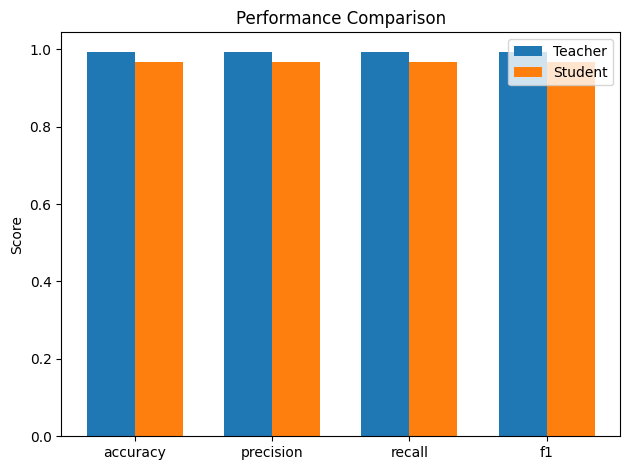

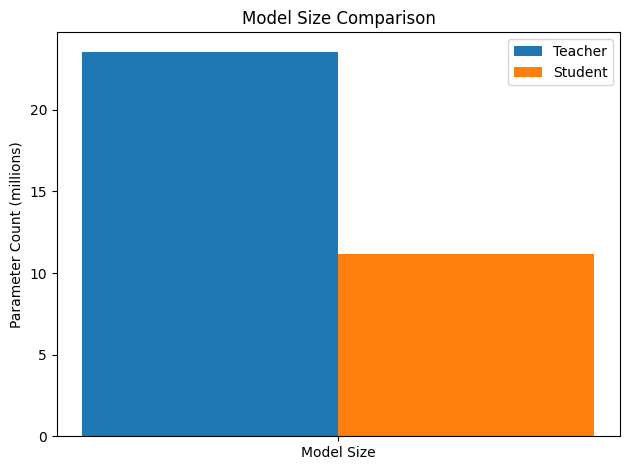

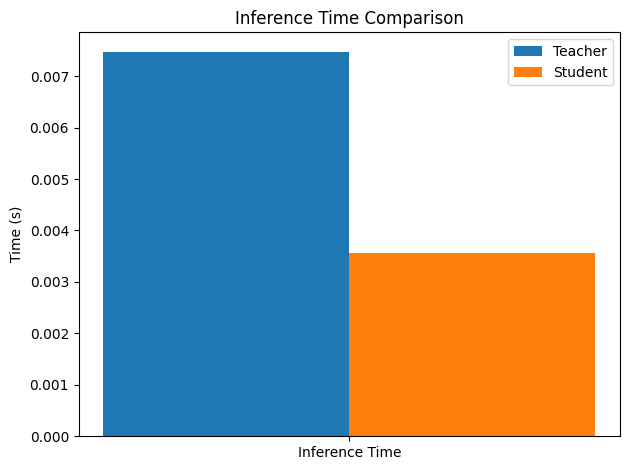

In [17]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, trainloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, trainloader)['metrics']
print(performance_metrics)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]

student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')

{'accuracy': (1.0, 1.0), 'precision': (1.0, 1.0), 'recall': (1.0, 1.0), 'f1': (1.0, 1.0)}


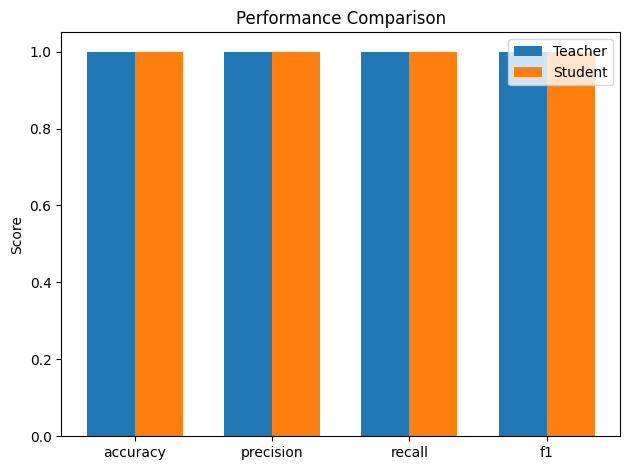

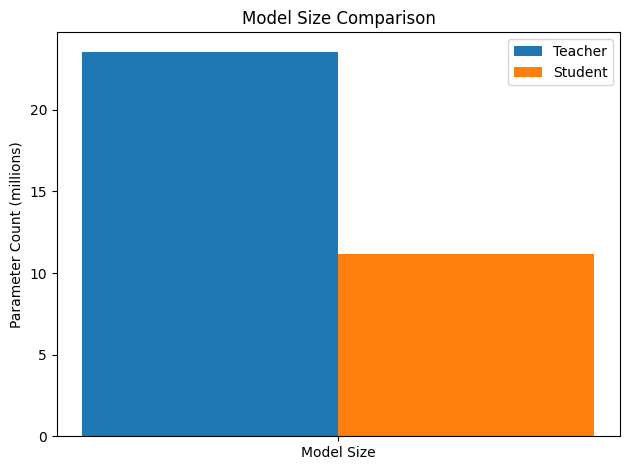

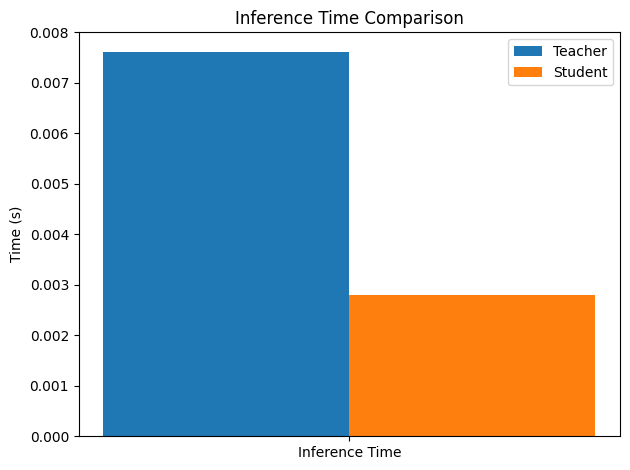

In [18]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, testloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)['metrics']
print(performance_metrics)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]

student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')